# Kernel : 'thesis'

In [3]:
import scipy
import re
import os
import datetime
import sklearn
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from glob import glob
from missingno import matrix

from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

from numpy.lib.stride_tricks import sliding_window_view
from dataProcessingHelpers import sliding_window

from importlib import reload
os.environ["WANDB_SILENT"] = "True"
# os.environ["WANDB_API_KEY"] = '5481593e8b571e303f5d4d410746bc2f35dabb41'
# os.environ["WANDB_MODE"] = "offline"
wandb.login()



from helpers import *
from train_and_test import *
from logger import *
from evaluator import *

# import models
from models.persistence import persistence, neutral_standardizer
from models import linear_model

# Common settings

Parameters
- **d_start**: (Remove all data older than this)
- **d_end**: (Remove all newer data from training/validation datasets)
- **max_lag**: (Number of past values used (at most) - used for pre-processing (24 at least for 24 hour rolling average))
- **pred_dist**: (Number of hours into the future to predict)
- **t_roll**: (n_hours of data for rolling temperature)
- **threshold_dict**: (Name of target variables and the thesholds used for that sensor)
- **temperature_name**: ( Which temperature sensor to use)
<!-- 
# Models
cross_validation = {
    'fn_kfold': 'TimeSeriesSplit',
    'folds': 5,
}

district_heating = {
    'n_rolling_temperature': 24,
    'dense_1': 5,
    'dense_2': 2,
    'activation_1': 'linear',
    'activation_2': 'linear',
}

pattern = {
    'pattern_length': 24,
    'pattern_constraint': None,
}

optimizer_params = {
    'class_name': 'Adam',
    'config': {
        'name': 'Adam',
        'learning_rate': 0.001,
        'decay': 0.0,
        'beta_1': 0.9,
        'beta_2': 0.999,
        'epsilon': 1e-07,
        'amsgrad': False
    }
}

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 20,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
}

relative_weights = [0.5, 1, 2, 5, 10, 15, 20, 30]



def District_heating():
    # District_heating = Sequential([
    #     Input((pred_dist, 1,)),
    #     Dense(district_heating['dense_1'],
    #           district_heating['activation_1']),
    #     Dense(district_heating['dense_2'],
    #           district_heating['activation_2']),
    # ], name='district_heating')
    
    DH = Sequential([
        Input((pred_dist, 1,)),
        
            Conv1D(filters=district_heating['dense_1'],
                   activation = district_heating['activation_1'],
                   kernel_size=1,
                   padding='causal'),
            Conv1D(filters=district_heating['dense_2'],
                   activation = district_heating['activation_2'],
                   kernel_size=1,
                   padding='causal'),
    ], name='district_heating')
    
    return DH
    

def Daily_pattern():
    Daily_pattern = Sequential([
        Input((pred_dist, pattern['pattern_length'])),
        Conv1D(filters=2,
               kernel_constraint = tf.keras.constraints.get(
                   pattern['pattern_constraint']),
               kernel_size=1,
                use_bias=False,
               padding='causal'),
        # Dense(2,
        #       activation='linear',
        #       use_bias=False,
        #       kernel_constraint=tf.keras.constraints.get(
        #           pattern['pattern_constraint']))
    ], name='pattern')
    return Daily_pattern



loss = 'Mean Squared Error'
# project = 'thesis_experiment_NWP_custom_table_test'
project = 'fresh_evaluation_test'

sample_weights_function = lambda x,classification : sw_func(x, thresholds, relative_weights,classification) -->


In [4]:
project = 'Experiment 3'

d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist= 60
t_roll = 24
threshold_dict = {'RVK-GEL': [0, 100, 200, 300, 400, 600, 800, 1000],
                  'RVK-BOD': [0, 25, 50, 75, 100, 125, 150, 200]}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = '1475_T'

# Cross-validation settings
fn_kfold = 'TimeSeriesSplit'
folds = 5

# optimizer settings
opt_name = 'Adam'

# Early stopping parameters
target_variable = 'val_loss'
min_delta = 0
patience = 20

early_stopper_params = {
    'monitor': target_variable,
    'min_delta': min_delta,
    'patience': patience,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
}

# District heating model settings
cross_validation = {
    'fn_kfold': fn_kfold,
    'folds': folds,
}

# district_heating_layers = {
#     'Dense_0' : {'units':5,'activation':'relu'},
#     'Dense_1' : {'units':2,'activation':'relu'},
# }

district_heating_layers = {
    'Dense_0' : {'units':2,'activation':'linear'},
}

pattern_layers = {
    'Dense_0' : {'units':2,'activation':'linear'},
}

def District_heating():
    # District_heating = Sequential([
    #     Input((pred_dist, 1,)),
    #     Dense(district_heating['dense_1'],
    #           district_heating['activation_1']),
    #     Dense(district_heating['dense_2'],
    #           district_heating['activation_2']),
    # ], name='district_heating')
    
    DH = Sequential([
        Input((pred_dist, 1,)),
        
            Conv1D(filters=district_heating['dense_1'],
                   activation = district_heating['activation_1'],
                   kernel_size=1,
                   padding='causal'),
            Conv1D(filters=district_heating['dense_2'],
                   activation = district_heating['activation_2'],
                   kernel_size=1,
                   padding='causal'),
    ], name='district_heating')
    
    return DH

def Daily_pattern():
    Daily_pattern = Sequential([
        Input((pred_dist, pattern['pattern_length'])),
        Conv1D(filters=2,
               kernel_constraint = tf.keras.constraints.get(
                   pattern['pattern_constraint']),
               kernel_size=1,
                use_bias=False,
               padding='causal'),
        # Dense(2,
        #       activation='linear',
        #       use_bias=False,
        #       kernel_constraint=tf.keras.constraints.get(
        #           pattern['pattern_constraint']))
    ], name='pattern')
    return Daily_pattern


DH = construct_sequential(district_heating_layers,'District_heating')
DH = construct_sequential(pattern_layers,'Pattern')



relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
# relative_weights = [0.5, 1, 2, 5, 10, 15, 20, 30]
sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)


# load data

In [3]:
X1,X2,X3,Y12 = get_NWP_data(threshold_dict,temperature_name,max_lag,pred_dist,d_start,d_end)

In [6]:
wandb.init(project=project, config={})



In [8]:
x = np.arange(0,10) + 10 * i

ys = []
for i in range(5):
    y = np.random.random(10)*i
    ys.append(ys)
data = [[x_, y_, f_] for (x_, y_, f_) in zip(x, y, f)]
table = wandb.Table(data=data, columns = ["x", "y","fold"])
wandb.log({"my_custom_plot_id" : wandb.plot.line_series(
    
    title="Custom Y vs X Line Plot")})


IndentationError: expected an indented block (Temp/ipykernel_30212/2071047885.py, line 5)

In [ ]:
def sw_func(
    y,
    thresholds,
    rel_weigths,
    # temporal=False,
    # classification=False
    ):
    '''
    - n_samples x n_sensors
        return: (n_samples, ) weights
    - n_samples x n_steps x n_sensors
        return: (n_samples, n_steps)
    '''
    y_shape = y.shape

    # Specific handling for classification (VERY UNCERTAIN THAT THIS IS A CORRECT IMPLEMENTATION)
    # if classification:
    #     weights = np.ones(y.shape)
    #     for i, w in enumerate(rel_weigths):
    #         weights[y[..., 0, i] == 1, 0] = w
    #         weights[y[..., 1, i] == 1, 1] = w
    #     return weights.mean(axis=(2, 3))
    
    weights = np.ones(y.shape)
    for (t1, t2), w in zip(thresholds.T, rel_weigths):
        weights[y[..., 0] >= t1, 0] = w
        weights[y[..., 1] >= t2, 1] = w

    sample_weights = np.apply_over_axes(np.sum, weights, range(1,weights.ndim)).ravel()
    return sample_weights/np.min(sample_weights) # So the smallest weight is 1

In [ ]:
# b = np.arange(10)
# A = np.zeros((10,5,2))
# if A.shape
# A[:] = np.tile(b,(5,2,1)).transpose((2,0,1))
# A[:] = np.tile(b,(5,2,1)).transpose(())
# np.all(A[0] == b[0]),np.all(A[1] == b[1]),

(True, True)

In [ ]:
A[0]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
np.tile(b,(5,1)).T

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9]])

In [ ]:

A[:] = np.repeat(b.reshape(
    
    [:,np.newaxis],axis=1,repeats = 5)
A

In [ ]:
# relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
relative_weights = [1, 1, 2, 5, 10, 15, 20, 30]
sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)

# Baseline model - persistence forecasting

In [ ]:
config_baseline = {
    'name': 'Predict last',
    'cross_validation': cross_validation,
    'thresholds': thresholds
}
# run = wandb.init(project=project, config=config_baseline)
baseline_results = train_and_test(model_constructor=persistence,
                                  input_data=Y12,
                                  output_data=Y12,
                                  config=config_baseline,
                                #   config=wandb.config,
                                  standardizer=neutral_standardizer)

baseline_eval_dict = evaluate_results(baseline_results['iop'],
                                      config_baseline['thresholds'],
                                      regression=True)
log_results(baseline_eval_dict, project, config_baseline)
# run.finish()


TypeError: evaluate_results() got an unexpected keyword argument 'regression'

Error: plotly is required to log interactive plots, install with: pip install plotly or convert the plot to an image with `wandb.Image(plt)`

<Figure size 432x288 with 0 Axes>

In [ ]:
wandb.log({'test':5})


In [ ]:
# def compute_classification(fold_data,config):
#     pred_dist = fold_data['Y_train_pred'].shape[1]
#     n_thresh = config['thresholds'].shape[1]
    
#     # sigmoid output
#     classification_layer = Sequential([
#         Input((pred_dist, 2)),
#         Reshape((pred_dist, 2, 1)),
#         Conv1D(n_thresh, 1, activation='sigmoid'),
#     ], 'classification_output')
    
#     classification_layer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#                                  loss=tf.losses.binary_crossentropy)
    
#     fold_data['Y_train_cls'] = np.zeros(fold_data['Y_train'].shape + (8,))
#     fold_data['Y_val_cls'] = np.zeros(fold_data['Y_val'].shape + (8,))
#     for i, (t1, t2) in enumerate(thresholds.T):
#         fold_data['Y_train_cls'][:, :, 0, i] = (fold_data['Y_train'][:, :, 0] > t1)*1
#         fold_data['Y_train_cls'][:, :, 0, i] = (fold_data['Y_train'][:, :, 1] > t2)*1
        
#         fold_data['Y_val_cls'][:, :, 0, i] = (fold_data['Y_val'][:, :, 0] > t1)*1
#         fold_data['Y_val_cls'][:, :, 0, i] = (fold_data['Y_val'][:, :, 1] > t2)*1

#     tmp = classification_layer.predict(fold_data['Y_train_pred'])
#     classification_layer.fit(fold_data['Y_train_pred'],fold_data['Y_train_cls'],epochs = 40,verbose = 0)
    
#     fold_data['Y_train_pred_cls'] = classification_layer.predict(fold_data['Y_train_pred'])
#     fold_data['y_pred_val_cls'] = classification_layer.predict(fold_data['Y_val_pred'])
    
    
# compute_classification(baseline_results['iop'][0],config_baseline)

# Linear models

### Ridge regression with only NWP data
#### Training setup

In [ ]:


# def train_ridge_regression(alpha=0):
alpha = 5
config_linear = {
    'name': 'Ridge regression with NWP',
    'loss': loss,
    'cross_validation': cross_validation,
    'alpha': alpha,
    'thresholds': thresholds
}
# run = wandb.init(config=config_linear, project=project)

X1_tmp = X1.reshape(-1, pred_dist, 100)

linear_results = train_and_test(model_constructor=linear_model.linear_model,
                                input_data=X1_tmp,
                                output_data=Y12,
                                config=config_linear,
                                # config=wandb.config,
                                )

linear_eval_dict = evaluate_results(linear_results['iop'],
                                    config_linear['thresholds'],
                                    regression=True)

# log_results(linear_eval_dict, project, wandb.config)
# run.finish()

# linear_eval_dict = train_ridge_regression(5)

#### Parameter sweep

In [ ]:
alphas = np.concatenate([[0], np.logspace(0, 9, 10*3-2)]).round(2).tolist()

sweep_config_linear = {
    "name": "Ridge regression with NWP sweep",
    "method": "grid",
    "parameters": {
        "alpha": {
            "values": alphas
        },
    }
}

sweep_id = wandb.sweep(sweep_config_linear, project=project)
wandb.agent(sweep_id, function=train_ridge_regression, count=len(alphas))
# wandb.agent(sweep_id, function=train_ridge_regression, count=5)


### Ridge regression with NWP and temperature
#### Training setup

In [ ]:
reload(linear_model)

# def train_ridge_regression_w_temp(alpha=0):
alpha = 0
config_linear_w_temp = {
    'name': 'Ridge regression with NWP and temperature',
    'loss': loss,
    'cross_validation': cross_validation,
    'alpha': alpha,
    'thresholds': thresholds
}

# run = wandb.init(config=config_linear_w_temp)
X1_tmp = X1.reshape(-1, pred_dist, 100)
X2_tmp = X2.reshape(-1, pred_dist, 1)

linear_w_temp_results = train_and_test(model_constructor=linear_model.linear_model,
                                        input_data=[X1_tmp, X2_tmp],
                                        output_data=Y12,
                                        config = config_linear_w_temp,
                                        )

linear_w_temp_eval_dict = evaluate_results(linear_w_temp_results['iop'],
                                            config_linear_w_temp['thresholds'],
                                            regression=True)

# log_results(linear_w_temp_eval_dict, project, wandb.config)
# run.finish()
# return linear_w_temp_eval_dict


#### Parameter sweep

In [ ]:
# alphas = np.concatenate([[0], np.logspace(0, 9, 10*3-2)]).round(2).tolist()
# sweep_config_linear_w_temp = {
#     "name": "Ridge regression with NWP and temperature sweep",
#     "method": "grid",
#     "parameters": {
#         "alpha": {
#             "values": alphas
#         },
#     }
# }

# sweep_id = wandb.sweep(sweep_config_linear_w_temp, project=project)
# wandb.agent(sweep_id, function=train_ridge_regression_w_temp,
#             count=len(alphas))
# # wandb.agent(sweep_id, function=train_ridge_regression_w_temp, count=5)


## Ridge regression with NWP, temp and pattern
### Training setup

In [ ]:
# def train_ridge_regression_w_temp_and_pattern(alpha=0):
alpha = 5
config_linear_w_temp_and_pattern = {
    'name': 'Linear model w temp and pattern',
    'loss': loss,
    'cross_validation': cross_validation,
    'alpha': alpha,
    'thresholds': thresholds
}

# from Models import LinearModel
# run = wandb.init(project=project, config=config_linear_w_temp_and_pattern)

X1_tmp = X1.reshape(-1, pred_dist, 100)
X2_tmp = X2.reshape(-1, pred_dist, 1)
X3_tmp = X3.reshape(-1, pred_dist, 24)

linear_w_temp_and_pattern_results = train_and_test(model_constructor=linear_model.linear_model,
                                                    input_data=[X1_tmp, X2_tmp, X3_tmp],#np.c_[X1_tmp, X2_tmp, X3_tmp],
                                                    output_data=Y12,
                                                    config = config_linear_w_temp_and_pattern,
                                                    )

linear_w_temp_and_pattern_eval_dict = evaluate_results(linear_w_temp_and_pattern_results['iop'],
                                                        config_linear_w_temp_and_pattern['thresholds'],
                                                        regression=True)

# log_results(linear_w_temp_and_pattern_eval_dict, project, wandb.config)
# run.finish()
# return linear_w_temp_and_pattern_results_eval_dict
# linear_w_temp_and_pattern_results_eval_dict = train_ridge_regression_w_temp_and_pattern(5)

### Parameter sweep

In [ ]:
# alphas = np.concatenate([[0], np.logspace(0, 9, 10*3-2)]).round(2).tolist()
# sweep_config_linear_w_temp_and_pattern = {
#     "name": "Ridge regression with NWP, temperature and pattern sweep",
#     "method": "grid",
#     "parameters": {
#         "alpha": {
#             "values": alphas
#         },
#     }
# }

# sweep_id = wandb.sweep(sweep_config_linear_w_temp_and_pattern, project=project)
# wandb.agent(
#     sweep_id, function=train_ridge_regression_w_temp_and_pattern, count=len(alphas))
# # wandb.agent(sweep_id, function=train_ridge_regression_w_temp_and_pattern, count=5)


# Neural network models


In [ ]:
# def train_recurrent_model(random_seed=99,
#                           lag=5,
#                           lstm_units=10,
#                           initial_learning_rate=-1,
#                           final_learning_rate=-3.5,
#                           ):

random_seed=99,
lag=5,
lstm_units=10,
initial_learning_rate=-1,
final_learning_rate=-3.5,


config_recurrent_simple = {
    'name': 'Recurrent model with NWP',
    'random_seed': random_seed,
    'loss': loss,
    'cross_validation': cross_validation,
    'thresholds': thresholds,

    # Tf stuff
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    'lag': lag,

    'lstm_units': lstm_units,
    'rainfall_runoff': {
        'dense_1': {
            'units': 2,
            'activation': 'linear'
        }
    },

    # Training
    'batch_size': 24*3,
    'epochs': 100,

    'initial_learning_rate': initial_learning_rate,
    'final_learning_rate': final_learning_rate,
    'intervals': 100,
}

# wandb.init(config=config_recurrent_simple, project=project)

def simple_recurrent_model():
    general_params = wandb.config
    rr_params = general_params['rainfall_runoff']
    tf.random.set_seed(general_params['random_seed'])
    model = Sequential([Input((pred_dist, general_params['lag'], 100)),
                        TimeDistributed(
                            LSTM(general_params['lstm_units'])),
                        Dense(**rr_params['dense_1']), ],
                        name='NWP')
    optimizer = tf.keras.optimizers.get(general_params['optimizer'])
    metrics = [tf.keras.metrics.MAE, tf.losses.MSE, tfp.stats.correlation]
    model.compile(optimizer=optimizer, loss=tf.losses.MSE, metrics=metrics)
    return model

# Data prep
n, f, *p = X1.shape

recurr_lag = wandb.config['lag']
X1_tmp = X1.reshape(n, f, -1)
Y12_tmp = np.c_[Y1[:, :, np.newaxis], Y2[:, :, np.newaxis]]
X1_tmp_2 = np.concatenate(
    [np.zeros((n, recurr_lag-1, 100)), X1_tmp], axis=1)
X1_tmp_3 = sliding_window_view(X1_tmp_2, (1, recurr_lag, 100)).squeeze()
X1_tmp_3.shape



with tf.device('/gpu:0'):
    # with tf.device('/cpu:0'):
    recurr_results = train_and_test(model_constructor=simple_recurrent_model,
                                    input_data=X1_tmp_3,
                                    output_data=Y12_tmp,
                                    config=wandb.config,

                                    # Kwargs
                                    batch_size=wandb.config['batch_size'],
                                    epochs=wandb.config['epochs'],
                                    shuffle=True,
                                    callbacks=[
                                        lr_scheduler_recurr,
                                        early_stopper,
                                        # logging_callback
                                    ],
                                    verbose=0
                                    )

recurr_eval_dict = evaluate_results(recurr_results['iop'],
                                    wandb.config['thresholds'],
                                    regression=True)

log_results(recurr_eval_dict, project, wandb.config)
run.finish()
# return recurr_eval_dict

# train_recurrent_model()


In [ ]:
random_seed_list = [0, 1, 2]
lag_list = [2, 3, 4, 5]
lstm_units_list = [1, 5, 10, 20]
initial_learning_rate_list = [0, -1, -2]
final_learning_rate_list = [-3, -4, -5]

total_tries = len(random_seed_list) * len(lag_list) * len(lstm_units_list) * \
    len(initial_learning_rate_list) * len(final_learning_rate_list)
print('total tries:', total_tries)


total tries: 432


In [ ]:
sweep_config_recurr = {
    "name": "'Recurrent model with NWP sweep",
    "method": "grid",
    "parameters": {
        "random_seed": {
            "values": random_seed_list
        },
        "lag": {
            "values": lag_list
        },
        "lstm_units": {
            "values": lstm_units_list
        },
        "initial_learning_rate": {
            "values": initial_learning_rate_list
        },
        "final_learning_rate": {
            "values": final_learning_rate_list
        },
    }
}

sweep_id_recurr = wandb.sweep(sweep_config_recurr, project=project)
wandb.agent(sweep_id_recurr, function=train_recurrent_model, count=total_tries)
# wandb.agent(sweep_id, function=train_ridge_regression_w_temp_and_pattern, count=5)


Create sweep with ID: l9922ftz
Sweep URL: https://wandb.ai/sverrirhd/fresh_evaluation_test/sweeps/l9922ftz


In [ ]:
sweep_config_recurr = {
    "name": "'Recurrent model with NWP sweep",
    # "method" : "grid",
    "method": "bayes",
    "metric": {
        "goal": "minimize",
        "name": "total_mean_squared_error"
    },
    "parameters": {
        "random_seed": {
            "values": random_seed_list
        },
        "lag": {
            "values": lag_list
        },
        "lstm_units": {
            "values": lstm_units_list
        },
        "initial_learning_rate": {
            "values": initial_learning_rate_list
        },
        "final_learning_rate": {
            "values": final_learning_rate_list
        },
    }
}

# sweep_id_recurr = wandb.sweep(sweep_config_recurr,project=project)
wandb.agent(sweep_id_recurr, function=train_recurrent_model, count=total_tries)
# wandb.agent(sweep_id, function=train_ridge_regression_w_temp_and_pattern, count=5)


Create sweep with ID: c66vl4n6
Sweep URL: https://wandb.ai/sverrirhd/fresh_evaluation_test/sweeps/c66vl4n6


### Simple conceptual model with rainfall

In [7]:
def conceptual_model_simple(config = wandb.config):
    tf.random.set_seed(config['random_seed'])

    # Rainfall runoff only input: rain-gauge
    RR = Sequential([
        Input(shape = (pred_dist, 100)),
        Conv1D(filters=config['filters'],
               kernel_size=config['lag'],
               padding='causal',
               activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(
            10**config['l2_regularization'])),
        Dense(config['rainfall_runoff']['dense_1'],
              config['rainfall_runoff']['activation_1']), ], 'rainfall')

    # inputs
    RR_input = Input(shape = (pred_dist, 100), name='rainfall_input')
    DH_input = Input((pred_dist, 1,), name='DH_input')
    DP_input = Input(
        (pred_dist, config['pattern']['pattern_length'],), name='pattern_input')

    DH = District_heating()
    PA = Daily_pattern()
    RR_output = RR(Rainfall_runoff_input)
    DH_output = DH(District_heating_input)
    DP_output = PA(Daily_pattern_input)

    combined_output = tf.keras.layers.Add()([RR_output,
                                            DH_output,
                                            DP_output])

    model = tf.keras.Model([Rainfall_runoff_input,
                            District_heating_input,
                            Daily_pattern_input],
                           combined_output)
    optimizer = tf.keras.optimizers.get(config['optimizer'])
    model.compile(optimizer=optimizer,
                  loss=lambda a, b: tf.losses.MSE(
                      a, b) + tf.losses.MAE(a, b),
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])

    return model


def make_config_conceptual_simple(random_seed,
                                  lag,
                                  filters,
                                  l2_regularization,
                                  initial_learning_rate,
                                  final_learning_rate):

    config_conceptual_simple = {
        'name': 'Simple conceptual model',
        'random_seed': 99,
        'loss': loss,
        'cross_validation': cross_validation,
        'optimizer': optimizer_params,
        'early_stopper': early_stopper_params,
        # model
        'district_heating': district_heating,
        'pattern': pattern,
        # RR model
        'filters': filters,
        'lag': lag,
        'l2_regularization': l2_regularization,
        'rainfall_runoff': {
            'dense_1': 2,
            'activation_1': 'linear',
        },
        # Training
        'batch_size': 64,
        'epochs': 120,
        'initial_learning_rate': initial_learning_rate,
        'final_learning_rate': final_learning_rate,
        'intervals': 100,
        'weights': [0.2, 0.5, 1, 2, 5, 8, 10, 20],
        # Evaluation
        'thresholds': thresholds,
    }
    return config_conceptual_simple


def train_conceptual_simple(random_seed=99,
                            lag=5,
                            filters=10,
                            l2_regularization=0,
                            initial_learning_rate=-1,
                            final_learning_rate=-3.5):

    config_conceptual_simple = make_config_conceptual_simple(random_seed,
                                                             lag,
                                                             filters,
                                                             l2_regularization,
                                                             initial_learning_rate,
                                                             final_learning_rate)
    print(config_conceptual_simple)
    run = wandb.init(project=project, config=config_conceptual_simple)
    print(wandb.config)
    # logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
        lr_schedule, verbose=0)
    early_stopper = tf.keras.callbacks.EarlyStopping(
        **wandb.config['early_stopper'])

    n, f, *p = X1.shape

    X1_tmp = X1.reshape(n, f, -1)
    X2_tmp = X2.reshape(n, f, -1)
    X3_tmp = X3.reshape(n, f, -1)

    Y12_tmp = np.c_[Y1[:, :, np.newaxis], Y2[:, :, np.newaxis]]
    def lr_schedule_con_simple(epoch, lr):
        learning_rates = np.logspace(wandb.config['initial_learning_rate'],
                                     wandb.config['final_learning_rate'],
                                     wandb.config['intervals'])
        epochs = wandb.config['epochs']
        n_lr = wandb.config['intervals']
        return learning_rates[int(epoch/epochs * n_lr)]

    lr_scheduler_con_simple = tf.keras.callbacks.LearningRateScheduler(lr_schedule_con_simple, verbose=0)
    print(X1_tmp.shape, X2_tmp.shape, X3_tmp.shape,Y12_tmp.shape)
    # with tf.device('/gpu:0'):
    with tf.device('/cpu:0'):
        con_simple_results = train_and_test(
            model_constructor=conceptual_model_simple,
            input_data=[X1_tmp, X2_tmp, X3_tmp],
            output_data=Y12_tmp,
            config=wandb.config,

            # Kwargs
            batch_size=wandb.config['batch_size'],
            epochs=wandb.config['epochs'],
            shuffle=True,
            callbacks=[
                lr_scheduler_con_simple,
                early_stopper,
                # logging_callback
            ],
            verbose=1)

    con_simple_eval_dict = evaluate_results(con_simple_results['iop'],
                                            wandb.config['thresholds'],
                                            regression=True)

    log_results(con_simple_eval_dict, project, wandb.config)
    run.finish()
    return con_simple_eval_dict,con_simple_results

# 4:07 on CPU batch size 24
# 3:15 on CPU batch size 64
# 3:17 on CPU batch size 64
# 4:04 on GPU batch size 64
# con_simple_eval_dict,con_simple_results = train_conceptual_simple()

In [13]:
tf.keras.utils.plot_model(conceptual_model_simple(config_conceptual_simple),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)

NameError: name 'config_conceptual_simple' is not defined

In [ ]:
run = wandb.init(project=project,config={})

In [ ]:
wandb.log

<module 'wandb' from 'C:\\Users\\sverrirhd\\Anaconda3\\envs\\thesis\\lib\\site-packages\\wandb\\__init__.py'>

In [ ]:
random_seed_list = [0]
lag_list = [1, 2, 5]
filters_list = [5, 10, 20]
l2_regularization = [0,1,2,3,4,5]
initial_learning_rate_list = [1, 0, -1]
final_learning_rate_list = [-2, -3, -4]

total_tries = len(random_seed_list) * len(lag_list) * len(filters_list) * \
    len(initial_learning_rate_list) * len(final_learning_rate_list) * len(l2_regularization)
print('total tries:', total_tries)


total tries: 486


name: Conceptual model sweep
method: bayes
metric:
  goal: minimize
  name: val_mean_squared_error
parameters:
  l2_regularization:
    max:12
    min: -5
    distribution: uniform
  initial_learning_rate:
    max: 10
    min: -10
    distribution: uniform
  final_learning_rate:
    max: 10
    min: -10
    distribution: uniform
  filters:
    max: 100
    min: 1
    distribution: int_uniform
  lag:
    max: 55
    min: 1
    distribution: int_uniform


In [ ]:
sweep_config_con_simple = {
  "name": "Conceptual model sweep",
  "method": "bayes",
  "metric": {
    "goal": "minimize",
    "name": "total_mean_squared_error"
    },
  "parameters": {
    "l2_regularization": {
      "max": 8,
      "min": -2,
      'distribution': 'uniform',
      },
    "initial_learning_rate": {
      "max": 1,
      "min": -5,
      "distribution": "uniform",
      },
    "final_learning_rate": {
      "max": 1,
      "min": -5,
      "distribution": "uniform",
      },
    "filters": {
      "max": 100,
      "min": 1,
      "distribution": "int_uniform",
      },
    "lag": {
      "max": 55,
      "min": 1,
      "distribution": "int_uniform",
      },
    },
}
sweep_id_con_simple = 'sverrirhd/fresh_evaluation_test/gduonyw1'
# sweep_id_con_simple = wandb.sweep(sweep_config_con_simple, project=project)
wandb.agent(sweep_id_con_simple, function=train_conceptual_simple, count=200)

Traceback (most recent call last):
  File "C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\wandb\agents\pyagent.py", line 303, in _run_job
    self._function()
  File "C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_8596/2736909335.py", line 147, in train_conceptual_simple
    log_results(con_simple_eval_dict, project, wandb.config)
  File "C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_8596/3968300544.py", line 55, in log_results
    wandb.log(fold_evaluation_stats)
  File "C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\wandb\sdk\wandb_run.py", line 1229, in log
    self.history._row_add(data)
  File "C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\wandb\sdk\wandb_history.py", line 44, in _row_add
    self._flush()
  File "C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\wandb\sdk\wandb_history.py", line 59, in _flush
    self._callback(row=self._data, step=self._step)
  File "C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\wandb\s

In [ ]:
# sweep_config_con_simple = {
#     "name": "Conceptual model sweep",
#     "method": "bayes",
#     "metric": {
#         "goal": "minimize",
#         "name": "total_mean_squared_error"
#     },
#     # "method": "grid",
#     "parameters": {
#         "random_seed": {
#             "values": random_seed_list
#         },
#         "lag": {
#             "values": lag_list
#         },
#         "filters": {
#             "values": filters_list
#         },
#         "l2_regularization":{
#             "values": l2_regularization
#         },
#         "initial_learning_rate": {
#             "values": initial_learning_rate_list
#         },
#         "final_learning_rate": {
#             "values": final_learning_rate_list
#         },
#     }
# }
# sweep_id_con_simple = '7havkt6w'
sweep_id_con_simple = wandb.sweep(sweep_config_con_simple, project=project)
wandb.agent(sweep_id_con_simple, function=train_conceptual_simple, count=200)
# wandb.agent(sweep_id, function=train_ridge_regression_w_temp_and_pattern, count=5)


404 response executing GraphQL.
{"errors":[{"message":"could not find sweep sverrirhd/uncategorized/7havkt6w during createAgent","path":["createAgent"]}],"data":{"createAgent":null}}


CommError: could not find sweep sverrirhd/uncategorized/7havkt6w during createAgent

In [ ]:
# tf.keras.utils.plot_model(conceptual_model_simple(),
#                           show_layer_names=True,
#                           show_shapes=True,
#                           expand_nested=True)


### Simple conceptual model without rainfall

In [ ]:
config_conceptual_simple_no_rain = {
    'name': 'Simple conceptual model without rainfall',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,

    # Training
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
    # 'weights': [0.2, 0.5, 1, 2, 5, 8, 10, 20]
    'thresholds': thresholds,
}

wandb.init(project=project, config=config_conceptual_simple_no_rain)


def sample_weights_function(x): return sw_func(
    x, thresholds, wandb.config['weights'])


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


def conceptual_model_simple_no_rain():
    general_params = wandb.config
    DH_params = general_params['district_heating']

    tf.random.set_seed(general_params['random_seed'])

    # inputs
    District_heating_input = Input((pred_dist, 1,), name='DH_input')
    Daily_pattern_input = Input(
        (pred_dist, general_params['pattern']['pattern_length'],), name='pattern_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)

    combined_output = tf.keras.layers.add(
        [District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss=lambda a, b: tf.losses.MSE(a, b) + tf.losses.MAE(a, b),
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


# tf.keras.utils.plot_model(conceptual_model_simple_no_rain(),
#                           show_layer_names=True,
#                           show_shapes=True,
#                           expand_nested=True)


n, f, *p = X1.shape

X2_tmp = X2.reshape(n, f, -1)
X3_tmp = X3.reshape(n, f, -1)

Y12_tmp = np.c_[Y1[:, :, np.newaxis], Y2[:, :, np.newaxis]]

# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    con_simple_no_rain_results = train_and_test(
        model_constructor=conceptual_model_simple_no_rain,
        input_data=[
            X2_tmp,
            X3_tmp],
        output_data=Y12_tmp,
        config=wandb.config,

        # Kwargs
        batch_size=wandb.config['batch_size'],
        epochs=wandb.config['epochs'],
        shuffle=True,
        callbacks=[
            lr_scheduler,
            early_stopper,
            # logging_callback
        ],
        verbose=1)


con_simple_no_rain_eval_dict = evaluate_results(con_simple_no_rain_results['iop'],
                                                wandb.config['thresholds'],
                                                regression=True)

log_results(con_simple_no_rain_eval_dict, project, wandb.config)


Epoch 1/120
35/35 [==============================] - 1s 9ms/step - loss: 9415.2051 - mean_absolute_error: 48.4928 - mean_squared_error: 9366.7100 - correlation: 0.1293 - val_loss: 12044.0947 - val_mean_absolute_error: 54.9778 - val_mean_squared_error: 11989.1172 - val_correlation: 0.2704
Epoch 2/120
35/35 [==============================] - 0s 2ms/step - loss: 8748.9893 - mean_absolute_error: 45.5132 - mean_squared_error: 8703.4766 - correlation: 0.1334 - val_loss: 11326.6768 - val_mean_absolute_error: 52.4413 - val_mean_squared_error: 11274.2354 - val_correlation: 0.2688
Epoch 3/120
35/35 [==============================] - 0s 2ms/step - loss: 8270.8223 - mean_absolute_error: 43.6324 - mean_squared_error: 8227.1895 - correlation: 0.1334 - val_loss: 10806.7549 - val_mean_absolute_error: 50.7932 - val_mean_squared_error: 10755.9619 - val_correlation: 0.2676
Epoch 4/120
35/35 [==============================] - 0s 2ms/step - loss: 7922.9487 - mean_absolute_error: 42.2769 - mean_squared_erro

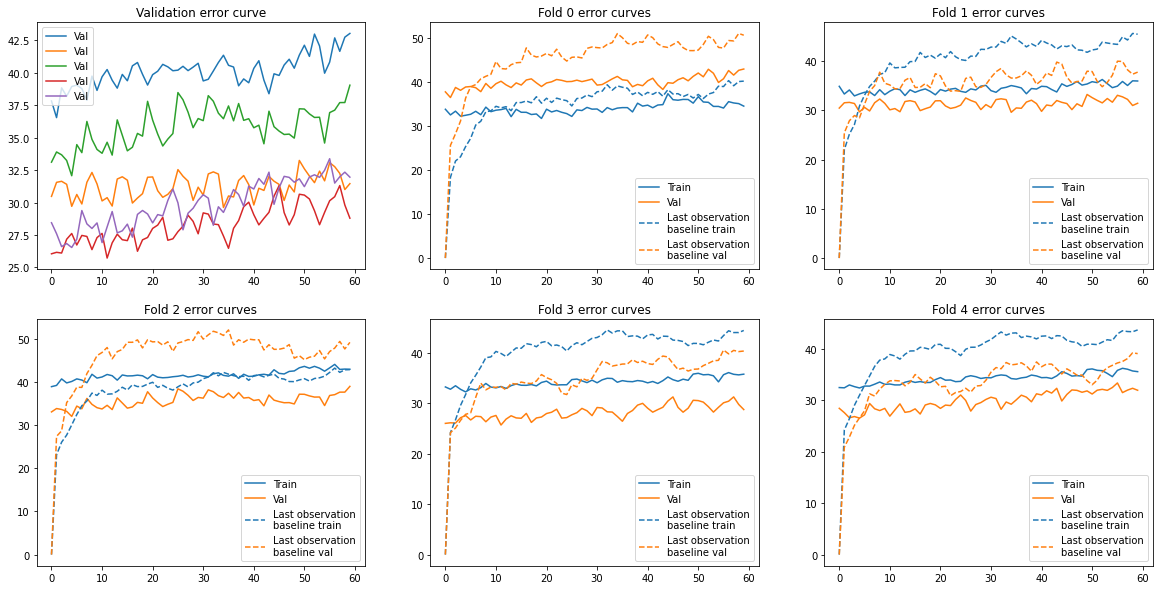

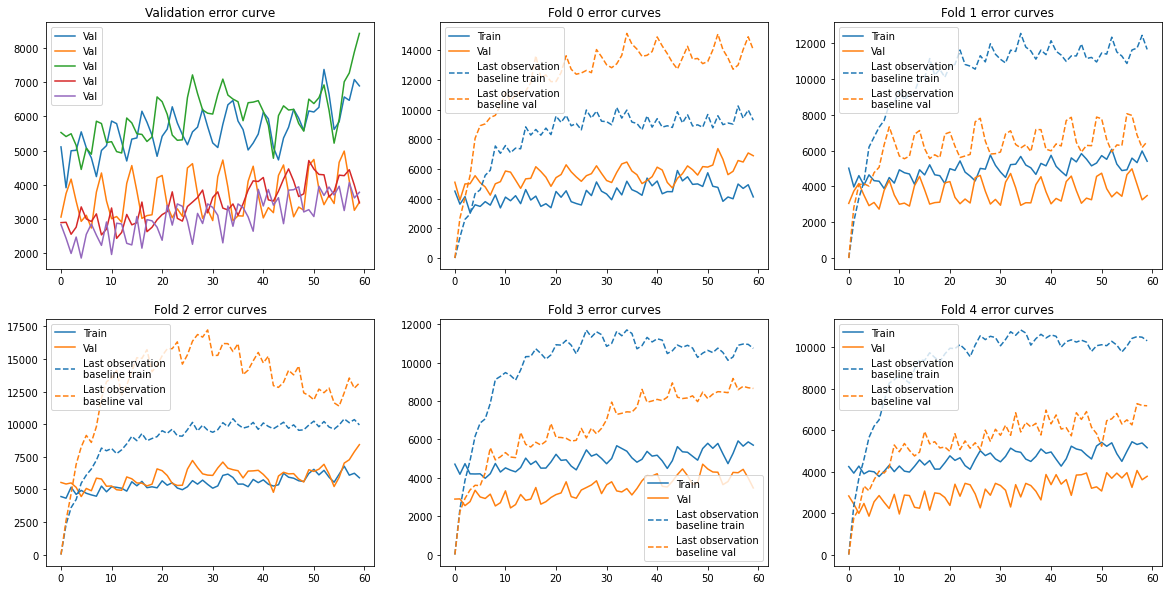

In [ ]:
def error_profiles(iop, metric='mae'):
    f, axes = plt.subplots(2, 3, figsize=(20, 10))
    for key, ax in zip(iop, axes.ravel()[1:]):
        model_results = iop[key]
        Y_val = model_results['Y_val']
        Y_val_pred = model_results['Y_val_pred']
        Y_train = model_results['Y_train']
        Y_train_pred = model_results['Y_train_pred']

        # Error pattern
        training_resid = Y_train - Y_train_pred
        testing_resid = Y_val - Y_val_pred
        resid_last_value_val = Y_val - Y_val[:, [0], :]
        resid_last_value_train = Y_train - Y_train[:, [0], :]

        if metric == 'mae':
            training_error = np.mean(np.abs(training_resid), axis=(0, 2))
            testing_error = np.mean(np.abs(testing_resid), axis=(0, 2))
            baseline_error_val = np.mean(
                np.abs(resid_last_value_val), axis=(0, 2))
            baseline_error_train = np.mean(
                np.abs(resid_last_value_train), axis=(0, 2))
        if metric == 'mse':
            training_error = np.mean(np.power(training_resid, 2), axis=(0, 2))
            testing_error = np.mean(np.power(testing_resid, 2), axis=(0, 2))
            baseline_error_val = np.mean(
                np.power(resid_last_value_val, 2), axis=(0, 2))
            baseline_error_train = np.mean(
                np.power(resid_last_value_train, 2), axis=(0, 2))

        line1 = ax.plot(training_error, label='Train')
        line2 = ax.plot(testing_error, label='Val')

        # Baseline error
        ax.plot(baseline_error_train, label='Last observation\nbaseline train',
                linestyle='--', color=line1[0].get_color())
        ax.plot(baseline_error_val, label='Last observation\nbaseline val',
                linestyle='--', color=line2[0].get_color())

        ax.legend()
        ax.set_title(f'Fold {key} error curves')

        axes[0, 0].plot(testing_error, label='Val')
    axes[0, 0].legend()
    axes[0, 0].set_title('Validation error curve')
    plt.show()


error_profiles(iop_con_simple, 'mae')
error_profiles(iop_con_simple, 'mse')


### Conceptual model with recurrent rainfall runoff

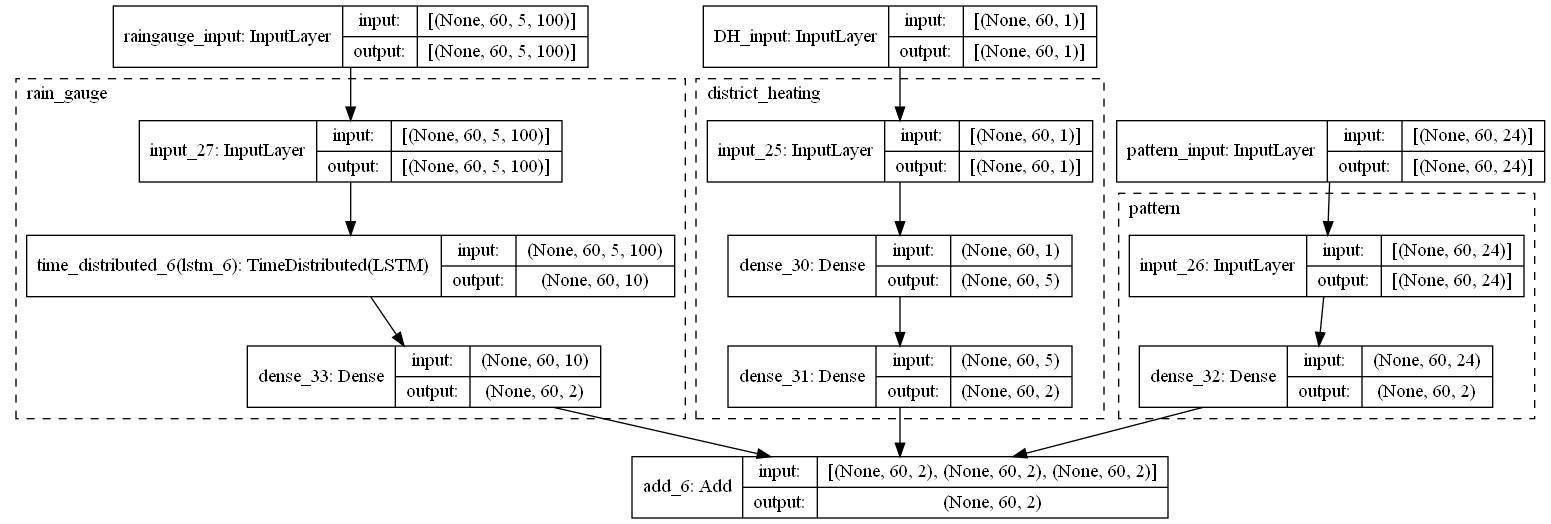

In [ ]:
lag = 12
config_conceptual_recurrent = {
    'name': 'Conceptual model with recurrent rainfall-runoff',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,

    # model
    'district_heating': district_heating,
    'pattern': pattern,
    'lag': 5,

    'rainfall_runoff': {
        'lstm': {
            'units': 10,
        },
        'dense_1': {
            'units': 2,
            'activation': 'linear'
        }
    },

    # Training
    'batch_size': 24,
    'epochs': 150,
    'learning_rate': {
        'inital_log': 0,
        'final_log': -3.5,
        'intervals': 100,
    },

}
wandb.init(project=project, config=config_conceptual_recurrent)


logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


def conceptual_model_recurrent():
    general_params = wandb.config
    DH_params = general_params['district_heating']
    rr_params = general_params['rainfall_runoff']

    tf.random.set_seed(99)

    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((pred_dist, 1,)),
        Dense(DH_params['dense_1'],
              DH_params['activation_1']),
        Dense(DH_params['dense_2'],
              DH_params['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input((pred_dist, general_params['pattern']['pattern_length'])),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  general_params['pattern']['pattern_constraint']))
    ], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([Input((pred_dist, general_params['lag'], 100)),
                                  TimeDistributed(LSTM(**rr_params['lstm'])),
                                  Dense(**rr_params['dense_1']), ],
                                 'rainfall')

    Rainfall_runoff_input = Input(
        (pred_dist, general_params['lag'], 100), name='raingauge_input')
    District_heating_input = Input((pred_dist, 1,), name='DH_input')
    Daily_pattern_input = Input(
        (pred_dist, general_params['pattern']['pattern_length'],), name='pattern_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([Rainfall_runoff_input,
                            District_heating_input,
                            Daily_pattern_input],
                           combined_output)

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_model_recurrent(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [ ]:
X1_tmp_3.shape, X2_tmp.shape, X3_tmp.shape


((4964, 60, 5, 100), (4964, 60, 1), (4964, 60, 24))

In [ ]:
n, f, *p = X1.shape

recurre_lag = wandb.config['lag']
X1_tmp = X1.reshape(n, f, -1)
Y12_tmp = np.c_[Y1[:, :, np.newaxis], Y2[:, :, np.newaxis]]
X1_tmp_2 = np.concatenate([np.zeros((n, recurre_lag-1, 100)), X1_tmp], axis=1)
X1_tmp_3 = sliding_window_view(X1_tmp_2, (1, recurre_lag, 100)).squeeze()

X2_tmp = X2.reshape(n, f, -1)
X3_tmp = X3.reshape(n, f, -1)

Y12_tmp = np.c_[Y1[:, :, np.newaxis], Y2[:, :, np.newaxis]]

with tf.device('/gpu:0'):
    # with tf.device('/cpu:0'):
    (history_dict_conceptual_recurrent,
     models_conceptual_recurrent, iop_conceptual_recurrent) =\
        train_and_test(model_constructor=conceptual_model_recurrent,
                       input_data=[
                           X1_tmp_3,
                           X2_tmp,
                           X3_tmp],
                       output_data=Y12_tmp,
                       thresholds=thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=True,
                       multiple_inputs=True,
                       # Kwargs
                       batch_size=wandb.config['batch_size'],
                       epochs=wandb.config['epochs'],
                       shuffle=True,
                       callbacks=[
                           lr_scheduler,
                           early_stopper,
                           # logging_callback
                       ],
                       verbose=1)


Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 3s 32ms/step - loss: 11203.2598 - mean_absolute_error: 59.0937 - mean_squared_error: 11203.2607 - correlation: -0.2198 - val_loss: 9408.8330 - val_mean_absolute_error: 50.5811 - val_mean_squared_error: 9408.8311 - val_correlation: 0.2501
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 1s 15ms/step - loss: 7139.5312 - mean_absolute_error: 40.4669 - mean_squared_error: 7139.5308 - correlation: 0.1288 - val_loss: 8906.0625 - val_mean_absolute_error: 44.9222 - val_mean_squared_error: 8906.0654 - val_correlation: 0.2173
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.9218207178777467.
35/35 [==============================] - 0s 13ms/step - loss: 6420.6196 - mean_absolute_error: 37.9971 - mean_squared_error: 6420.6187 - correlation: 0.3379 - val_loss: 8681.4121 - val_mean_absolu

# Basic NN

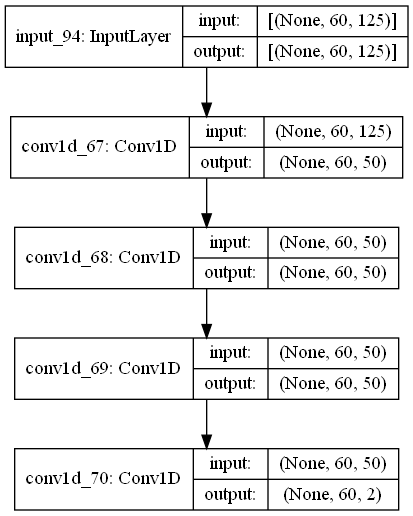

In [ ]:
lag = 2

early_stopper_params_tmp = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 50,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
}

config_basic_NN = {
    'name': 'Basic_NN',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params_tmp,

    # model
    'lag': lag,

    'NN': {
        'Conv1D_0': {
            'filters': 20,
            'kernel_size': lag,
            # 'kernel_regularizer': tf.keras.regularizers.l2(10.),
            'activation': 'relu',
            'padding': 'causal',
        },
        'Conv1D_1': {
            'filters': 20,
            'kernel_size': lag,
            # 'kernel_regularizer': tf.keras.regularizers.l2(10.),
            'activation': 'relu',
            'padding': 'causal',
        },
        'Conv1D_2': {
            'filters': 20,
            'kernel_size': lag,
            # 'kernel_regularizer': tf.keras.regularizers.l2(10.),
            'activation': 'relu',
            'padding': 'causal',
        },
        'Conv1D_3': {
            'filters': 2,
            'kernel_size': lag,
            'activation': 'linear',
            'padding': 'causal',
        },

        'dropout_0': {
            'rate': 0.3
        },

        'dropout_1': {
            'rate': 0.3
        },

    },
    # Training
    'batch_size': 24,
    'epochs': 150,
    'learning_rate': {
        'inital_log': 0,
        'final_log': -3.5,
        'intervals': 100,
    },

}

wandb.init(project='custom_CSI_table_test', config=config_basic_NN)
logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


def basic_NN():
    general_params = wandb.config
    NN_params = general_params['NN']
    tf.random.set_seed(99)

    # Rainfall runoff only input: rain-gauge
    model = Sequential([
        Input((pred_dist, 125)),
        # Conv1D(**NN_params['Conv1D_0'],
        # kernel_regularizer =tf.keras.regularizers.l2(1.),
        # ),
        # Dropout(**NN_params['dropout_0']),
        # Conv1D(**NN_params['Conv1D_1'],
        # kernel_regularizer =tf.keras.regularizers.l2(1.),
        # ),
        # Dropout(**NN_params['dropout_1']),
        # Conv1D(**NN_params['Conv1D_2'],
        # kernel_regularizer =tf.keras.regularizers.l2(1.),
        # ),
        Conv1D(**NN_params['Conv1D_3']),
    ])

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(basic_NN(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


n, f, *p = X1.shape

X1_tmp = X1.reshape(n, f, -1)
X2_tmp = X2.reshape(n, f, -1)
X3_tmp = X3.reshape(n, f, -1)
Y1_tmp = Y1.reshape(Y1.shape + (1,))
Y2_tmp = Y2.reshape(Y1.shape + (1,))


with tf.device('/gpu:0'):
    # with tf.device('/cpu:0'):
    (history_basic_NN, models_basic_NN, iop_basic_NN) =\
        train_and_test(model_constructor=basic_NN,
                       input_data=np.c_[X1_tmp, X2_tmp, X3_tmp],
                       output_data=np.c_[Y1_tmp, Y2_tmp],
                       thresholds=thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=True,
                       multiple_inputs=False,
                       unfold_after_split=False,

                       # Kwargs
                       batch_size=wandb.config['batch_size'],
                       epochs=wandb.config['epochs'],
                       shuffle=True,
                       callbacks=[
                           lr_scheduler,
                           early_stopper,
                           logging_callback
                       ],
                       verbose=1
                       )


Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 1s 13ms/step - loss: 9632.4160 - mean_absolute_error: 55.3594 - mean_squared_error: 9632.4150 - correlation: 0.4241 - val_loss: 8768.3076 - val_mean_absolute_error: 46.0550 - val_mean_squared_error: 8768.3086 - val_correlation: 0.3481
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 0s 6ms/step - loss: 6858.0742 - mean_absolute_error: 40.1991 - mean_squared_error: 6858.0747 - correlation: 0.6103 - val_loss: 8567.2363 - val_mean_absolute_error: 45.7709 - val_mean_squared_error: 8567.2373 - val_correlation: 0.3252
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.9218207178777467.
35/35 [==============================] - 0s 7ms/step - loss: 6693.6479 - mean_absolute_error: 39.1538 - mean_squared_error: 6693.6479 - correlation: 0.6411 - val_loss: 8419.3359 - val_mean_absolute_er

KeyboardInterrupt: 

# Classification tests
## Simple conseptual with sigmoid


# Something broke the model:

config_conceptual_classification_simple = {
    'name': 'Simple conceptual_classification model with sigmoid',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,

    'rainfall_runoff': {
        'lag': 2,
        'l2_regularization': 20,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    
    'filters': 10,
    'lag': 1,
    'l2_regularization': 0,
    
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
    # 'weights' : [0.2,0.5,1,2,5,8,10,15]
    # 'weights': [1, 1, 1, 1, 1, 1, 1, 1]
}

wandb.init(project=project, config=config_conceptual_classification_simple)

logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

# wandb.init(project=project, config=config)
n_classes = thresholds.shape[1]


def conceptual_classification_model_simple():
    general_params = wandb.config

    tf.random.set_seed(general_params['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature

    DH = District_heating()
    PA = Daily_pattern()

    # Rainfall runoff only input: rain-gauge
    RR = Sequential([
        Input(shape = (pred_dist, 100)),
        Conv1D(filters=general_params['filters'],
               kernel_size=general_params['lag'],
               padding='causal',
               activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(
            10**general_params['l2_regularization'])),
        # Conv1D(filters=general_params['rainfall_runoff']['dense_1'],
        #        kernel_size=1,
        #        padding='causal',
        #        activation=general_params['rainfall_runoff']['activation_1'])
        Dense(general_params['rainfall_runoff']['dense_1'],
              general_params['rainfall_runoff']['activation_1'])
        ], 'rainfall')

    # sigmoid output
    classification_layer = Sequential([
        Input((pred_dist, 2)),
        Reshape((pred_dist, 2, 1)),
        Conv1D(n_classes, 1, activation='sigmoid'),
        # Activation('sigmoid')
    ], 'classification_output')

    # inputs
    RR_input = Input(shape = (pred_dist, 100), name='rainfall_input')
    DH_input = Input((pred_dist, 1,), name='DH_input')
    DP_input = Input((pred_dist, general_params['pattern']['pattern_length'],), name='pattern_input')

    RR_output = RR(RR_input)
    DH_output = DH(DH_input)
    DP_output = PA(DP_input)

    addition_layer =  tf.keras.layers.Add(name = 'regression_output')
    combined_output = addition_layer([RR_output,DH_output,DP_output])
    
    classification_output = classification_layer(combined_output)

    model = tf.keras.Model([RR_input,
                            DH_input,
                            DP_input],
                        #    [
                               classification_output,
                            # combined_output,
                            # RR_output,
                            # DH_output,
                            # DP_output]
                           )

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss={
                      'classification_output':tf.losses.binary_crossentropy,
                    # 'regression_output':tf.losses.mean_squared_error
                    },
                #   metrics=[
                #       tf.keras.metrics.MAE,
                #            tf.losses.MSE, 
                #            tfp.stats.correlation
                #            ]
                  )

    return model


tf.keras.utils.plot_model(conceptual_classification_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


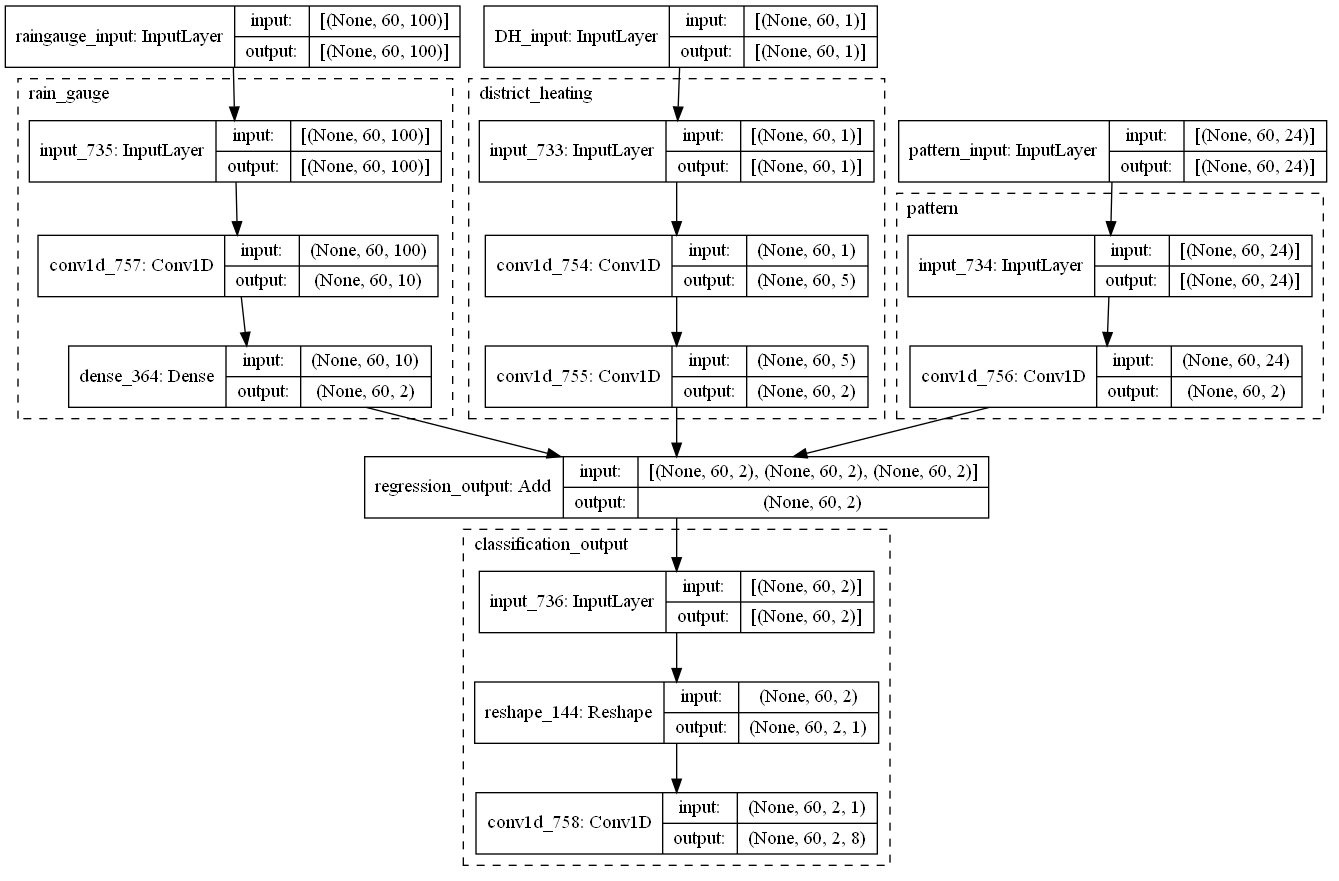

In [ ]:
config_conceptual_classification_simple = {
    'name': 'Simple conceptual_classification model with sigmoid',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,

    'rainfall_runoff': {
        'lag': 2,
        'l2_regularization': 20,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
    # 'weights' : [0.2,0.5,1,2,5,8,10,15]
    # 'weights': [1, 1, 1, 1, 1, 1, 1, 1]
}

wandb.init(project=project, config=config_conceptual_classification_simple)

logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

# wandb.init(project=project, config=config)
n_classes = thresholds.shape[1]


def conceptual_classification_model_simple():
    general_params = wandb.config
    DH_params = general_params['district_heating']
    RR_params = general_params['rainfall_runoff']

    tf.random.set_seed(general_params['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((pred_dist, 1,)),
        
            Conv1D(filters=DH_params['dense_1'],
                   activation = DH_params['activation_1'],
                   kernel_size=1,
                   padding='causal'),
            Conv1D(filters=DH_params['dense_2'],
                   activation = DH_params['activation_2'],
                   kernel_size=1,
                   padding='causal'),
        # Dense(DH_params['dense_1'],
        #       DH_params['activation_1']),
        # Dense(DH_params['dense_2'],
        #       DH_params['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input((pred_dist, general_params['pattern']['pattern_length'])),
        # Dense(2,
        #       activation='linear',
        #       use_bias=False,
        #       kernel_constraint=tf.keras.constraints.get(
        #           general_params['pattern']['pattern_constraint']))
        Conv1D(filters=2,
               kernel_constraint = tf.keras.constraints.get(
                   general_params['pattern']['pattern_constraint']),
               kernel_size=1,
               padding='causal'),
    ], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential(
        [
            Input((pred_dist, 100)),
            Conv1D(filters=10,
                   kernel_size=RR_params['lag'],
                   padding='causal'),
            Dense(RR_params['dense_1'],
                  RR_params['activation_1']),
        ], 'rain_gauge')

    # sigmoid output
    classification_layer = Sequential([
        Input((pred_dist, 2)),
        Reshape((pred_dist, 2, 1)),
        Conv1D(n_classes, 1, activation='sigmoid'),
        # Activation('sigmoid')
    ], 'classification_output')

    # inputs
    Rainfall_runoff_input = Input(
        (pred_dist, 100), name='raingauge_input')
    District_heating_input = Input((pred_dist, 1,), name='DH_input')
    Daily_pattern_input = Input(
        (pred_dist, general_params['pattern']['pattern_length'],), name='pattern_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add([
        Rainfall_runoff_output,
        District_heating_output,
        Daily_pattern_output
        ],name = 'regression_output')

    classification_output = classification_layer(combined_output)

    model = tf.keras.Model([Rainfall_runoff_input,
                            District_heating_input,
                            Daily_pattern_input],
                           [classification_output,
                            combined_output,
                            District_heating_output,
                            Daily_pattern_output,
                            Rainfall_runoff_output])

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss={
                    #   'classification_output':tf.losses.binary_crossentropy,
                    'regression_output':tf.losses.mean_squared_error
                    },
                #   metrics=[
                #       tf.keras.metrics.MAE,
                #            tf.losses.MSE, 
                #            tfp.stats.correlation
                #            ]
                  )

    return model


tf.keras.utils.plot_model(conceptual_classification_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [ ]:
n, f, *p = X1.shape

X1_tmp = X1.reshape(n, f, -1)
X2_tmp = X2.reshape(n, f, -1)
X3_tmp = X3.reshape(n, f, -1)

Y12_tmp = np.c_[Y1[:, :, np.newaxis], Y2[:, :, np.newaxis]]
# Y12_tmp = np.c_[Y2[:, :, np.newaxis], Y2[:, :, np.newaxis]]

Y12_tmp_cls = np.zeros(Y12_tmp.shape + (8,))
for i, (t1, t2) in enumerate(thresholds.T):
    Y12_tmp_cls[:, :, 0, i] = (Y12_tmp[:, :, 0] > t1)*1
    Y12_tmp_cls[:, :, 1, i] = (Y12_tmp[:, :, 1] > t2)*1


def sample_weights_function(x): return sw_func(
    x, thresholds, wandb.config['weights'], classification=True)


# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    con_class_simple_results = train_and_test(
        model_constructor=conceptual_classification_model_simple,
        input_data=[
            X1_tmp,
            X2_tmp,
            X3_tmp],
        output_data=\
            # [
            Y12_tmp_cls,
            # Y12_tmp,Y12_tmp,Y12_tmp,Y12_tmp],
        config = wandb.config,

        # Kwargs
        batch_size=wandb.config['batch_size'],
        epochs=wandb.config['epochs'],
        shuffle=True,
        callbacks=[
            lr_scheduler,
            early_stopper,
            logging_callback
        ],
        verbose=1,)


<class 'numpy.ndarray'>
b
Epoch 1/120
35/35 [==============================] - 1s 11ms/step - loss: 0.9903 - val_loss: 0.4377
Epoch 2/120
35/35 [==============================] - 0s 5ms/step - loss: 0.2100 - val_loss: 0.2474


C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1792 - val_loss: 0.1825
Epoch 4/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1542 - val_loss: 0.2555
Epoch 5/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1685 - val_loss: 0.2405
Epoch 6/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1702 - val_loss: 0.1837
Epoch 7/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1305 - val_loss: 0.2091
Epoch 8/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1404 - val_loss: 0.1632
Epoch 9/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1252 - val_loss: 0.1672
Epoch 10/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1269 - val_loss: 0.1836
Epoch 11/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1221 - val_loss: 0.1497
Epoch 12/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1254 - val_loss: 0.1946
Epoch 1

In [ ]:
# con_class_simple_eval_dict = evaluate_results(
#     con_class_simple_results['iop'],
#     thresholds,
#     regression=False)


# Maximize CSI wrt each threshold individually using the probabilities

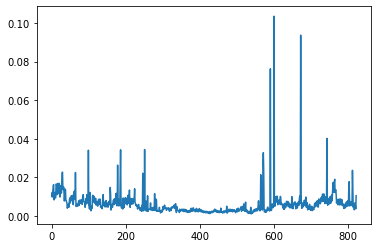

In [ ]:
# plt.plot(con_class_simple_results['iop'][fold]['Y_val'][:,0,0,5])
plt.plot(con_class_simple_results['iop'][fold]['Y_val_pred'][:,0,0,5])

In [ ]:
# con_class_simple_results['iop'][fold]['Y_train']

In [ ]:
def CLF_error(Y, Y_pred, thresh):
    Y_bool = Y == 1
    Y_pred_bool = Y_pred > thresh
    TP = np.sum(Y_bool & Y_pred_bool, axis=0)  # True True
    FP = np.sum(~Y_bool & Y_pred_bool, axis=0)  # False True
    TN = np.sum(~Y_bool & ~Y_pred_bool, axis=0)  # False False
    FN = np.sum(Y_bool & ~Y_pred_bool, axis=0)  # True False
    return TP, FP, TN, FN


fold = 4
y_trues_train = con_class_simple_results['iop'][fold]['Y_train']
y_preds_train = con_class_simple_results['iop'][fold]['Y_train_pred']

y_trues_val = con_class_simple_results['iop'][fold]['Y_val']
y_preds_val = con_class_simple_results['iop'][fold]['Y_val_pred']

thresh = 5
sensor = 0
prediction_distance = 60

y_true_train = y_trues_train[:,:prediction_distance, sensor, thresh].ravel()
y_pred_train = y_preds_train[:,:prediction_distance, sensor, thresh].ravel()

y_true_val = y_trues_val[:,:prediction_distance, sensor, thresh].ravel()
y_pred_val = y_preds_val[:,:prediction_distance, sensor, thresh].ravel()

performance_dict_val = {}
performance_dict_train = {}
performance_dict_val['CSI'] = []
performance_dict_train['CSI'] = []

performance_dict_val['precision'] = []
performance_dict_train['precision'] = []

performance_dict_val['recall'] = []
performance_dict_train['recall'] = []

performance_dict_val['false positive rate'] = []
performance_dict_train['false positive rate'] = []

performance_dict_val['true positive rate'] = []
performance_dict_train['true positive rate'] = []

performance_dict_val['f1'] = []
performance_dict_train['f1'] = []


prediction_thresholds = np.linspace(0,1,1000)
for pred_thresh in prediction_thresholds:
    TP, FP, TN, FN = CLF_error(y_true_val, y_pred_val, pred_thresh)
    performance_dict_val['CSI'].append(TP/(TP + FP + FN))
    performance_dict_val['precision'].append(TP/(TP+FP))
    performance_dict_val['recall'].append(TP/(TP+FN))
    performance_dict_val['false positive rate'].append(FP/(FP+TN))
    performance_dict_val['true positive rate'].append(TP/(TP+FN))
    performance_dict_val['f1'].append(TP/(TP + 1/2*(FP+FN)))
    
    TP, FP, TN, FN = CLF_error(y_true_train, y_pred_train, pred_thresh)
    performance_dict_train['CSI'].append(TP/(TP + FP + FN))
    performance_dict_train['precision'].append(TP/(TP+FP))
    performance_dict_train['recall'].append(TP/(TP+FN))
    performance_dict_train['false positive rate'].append(FP/(FP+TN))
    performance_dict_train['true positive rate'].append(TP/(TP+FN))
    performance_dict_train['f1'].append(TP/(TP + 1/2*(FP+FN)))
    
    

C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_30288/2392910360.py:53: RuntimeWarning: invalid value encountered in long_scalars
  performance_dict_val['precision'].append(TP/(TP+FP))
C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_30288/2392910360.py:61: RuntimeWarning: invalid value encountered in long_scalars
  performance_dict_train['precision'].append(TP/(TP+FP))


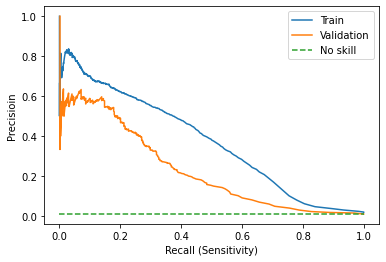

In [ ]:
plt.plot(performance_dict_train['recall'],performance_dict_train['precision'])
plt.plot(performance_dict_val['recall'],performance_dict_val['precision'])

no_skill = len(y_true_val[y_true_val==1]) / len(y_true_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precisioin')
plt.legend(['Train','Validation','No skill'])
plt.show()

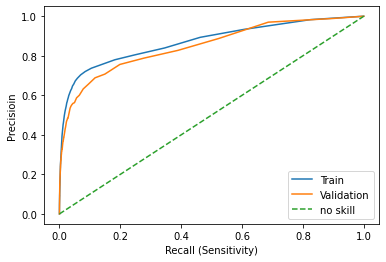

In [ ]:
plt.plot(performance_dict_train['false positive rate'],performance_dict_train['true positive rate'])
plt.plot(performance_dict_val['false positive rate'],performance_dict_val['true positive rate'])
plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precisioin')
plt.legend(['Train','Validation','no skill'])

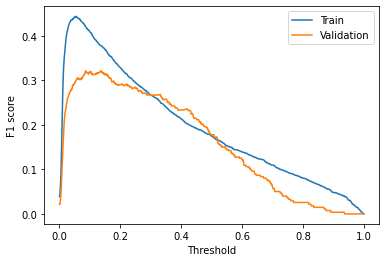

In [ ]:
plt.plot(prediction_thresholds,performance_dict_train['f1'])
plt.plot(prediction_thresholds,performance_dict_val['f1'])
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.legend(['Train','Validation','no skill'])

# Check a few instances

In [ ]:
# con_class_simple_results['iop'][0]['Y_val'][1]

In [ ]:

fold = 4
# Classification
y_trues_train = con_class_simple_results['iop'][fold]['Y_train'][0]
y_preds_train = con_class_simple_results['iop'][fold]['Y_train_pred'][0]

y_trues_val = con_class_simple_results['iop'][fold]['Y_val'][0]
y_preds_val = con_class_simple_results['iop'][fold]['Y_val_pred'][0]

# regression
yr_trues_train = con_class_simple_results['iop'][fold]['Y_train'][0]
yr_preds_train = con_class_simple_results['iop'][fold]['Y_train_pred'][0]

yr_trues_val = con_class_simple_results['iop'][fold]['Y_val'][0]
yr_preds_val = con_class_simple_results['iop'][fold]['Y_val_pred'][0]

thresh = 5
sensor = 0
prediction_distance = 5
# Classification
# y_true_train = y_trues_train[:,prediction_distance, sensor, thresh]
# y_pred_train = y_preds_train[:,prediction_distance, sensor, thresh]

# y_true_val = y_trues_val[:,prediction_distance, sensor, thresh]
# y_pred_val = y_preds_val[:,prediction_distance, sensor, thresh]

# regression
yr_true_train = yr_trues_train[:,prediction_distance, sensor]
yr_pred_train = yr_preds_train[:,prediction_distance, sensor]

yr_true_val = yr_trues_val[:,prediction_distance, sensor]
yr_pred_val = yr_preds_val[:,prediction_distance, sensor]
    
    

In [ ]:
con_class_simple_results['iop'][fold]['X_train'][1].shape

(4124, 60, 1)

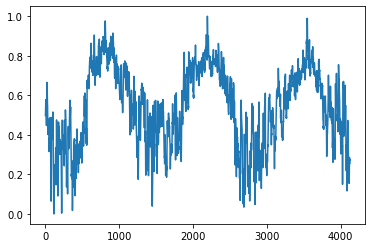

In [ ]:
plt.plot(con_class_simple_results['iop'][fold]['X_train'][1][:,0])

In [ ]:
yr_preds_train.shape

(4124, 60, 2)

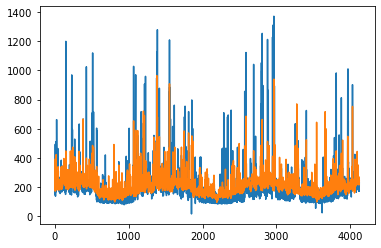

In [ ]:
plt.plot(yr_true_train)
plt.plot(yr_pred_train)

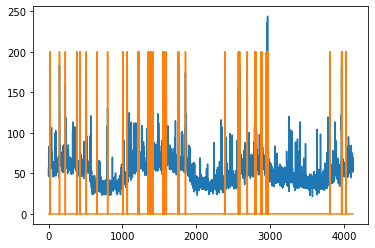

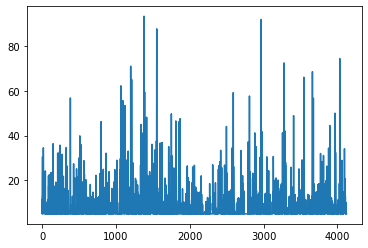

In [ ]:
plt.plot(yr_true_train)
plt.plot(y_true_train*200)
plt.show()

plt.plot(yr_pred_train)
# plt.plot(y_pred_train*200)
plt.show()

In [ ]:
# plt.plot(con_simple_results['iop'][4]['Y_val'][:,5,0])
# plt.plot(con_simple_results['iop'][4]['Y_val_pred'][:,5,0])
# plt.show()

# plt.plot(con_simple_results['iop'][4]['Y_val'][:,5,1])
# plt.plot(con_simple_results['iop'][4]['Y_val_pred'][:,5,1])
# plt.show()

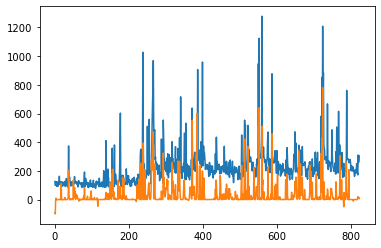

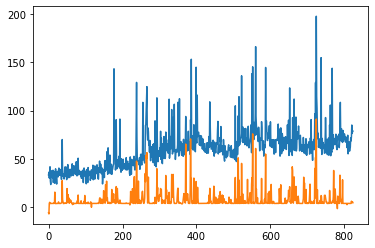

In [ ]:
plt.plot(con_class_simple_results['iop'][0]['Y_val'][1][:,5,0])
plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][1][:,5,0])
plt.show()

plt.plot(con_class_simple_results['iop'][0]['Y_val'][1][:,5,1])
plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][1][:,5,1])
plt.show()

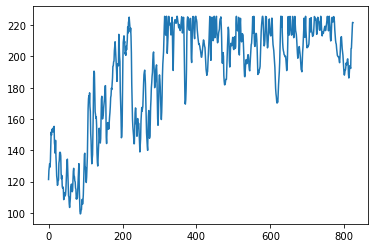

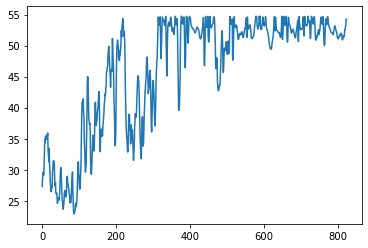

In [ ]:
# Rainfall part
plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][2][:,5,0])
plt.show()

plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][2][:,5,1])
plt.show()

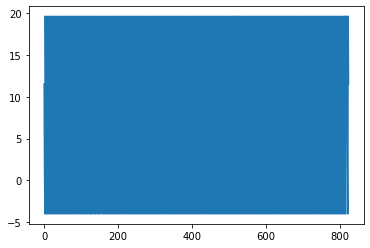

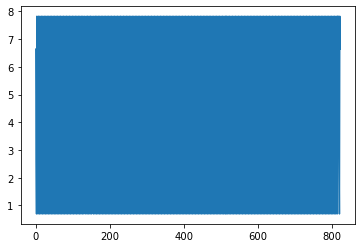

In [ ]:
# District heating part
plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][3][:,5,0])
plt.show()

plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][3][:,5,1])
plt.show()

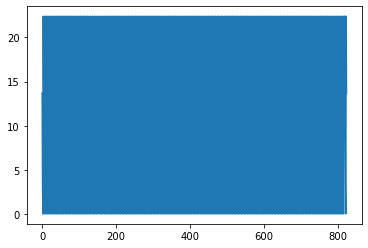

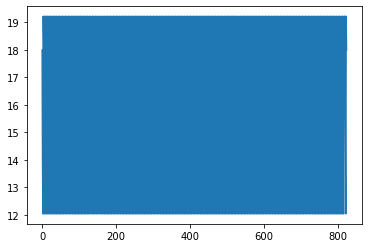

In [ ]:
# Pattern part
plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][4][:,5,0])
plt.show()

plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][4][:,5,1])
plt.show()

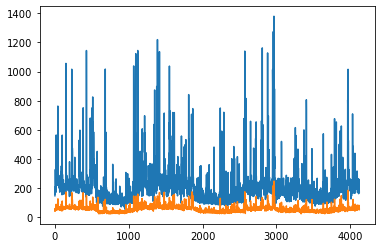

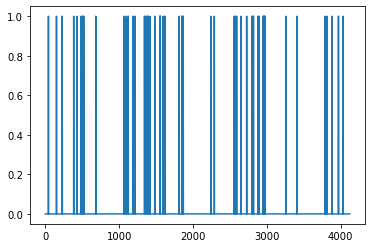

In [ ]:
plt.plot(con_class_simple_results['iop'][fold]['Y_train'][0][:,0,0,5])
# plt.plot(con_class_simple_results['iop'][fold]['Y_train'][3][:,0,1])

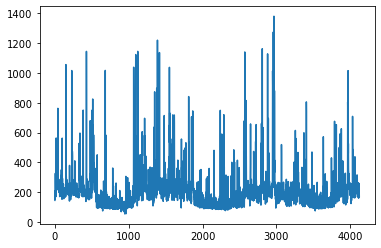

In [ ]:
plt.plot(con_class_simple_results['iop'][fold]['Y_train'][1][:,0,0])

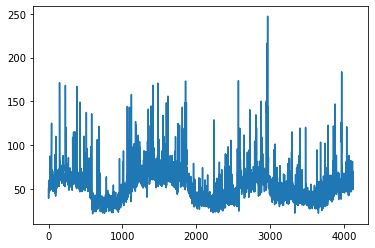

In [ ]:
plt.plot(con_class_simple_results['iop'][fold]['Y_train'][1][:,0,1])

In [ ]:
con_class_simple_results['iop'][fold]['Y_train']

[array([[[[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 0.]],
 
         [[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 0.]],
 
         [[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 1., ..., 0., 0., 0.]],
 
         [[1., 1., 1., ..., 0., 0., 0.],
          [1., 1., 1., ..., 0., 0., 0.]],
 
         [[1., 1., 1., ..., 0., 0., 0.],
          [1., 1., 1., ..., 0., 0., 0.]]],
 
 
        [[[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 0.]],
 
         [[1., 1., 1., ..., 0., 0., 0.],
          [1., 1., 1., ..., 0., 0., 0.]],
 
         [[1., 1., 1., ..., 0., 0., 0.],
          [1., 1., 1., ..., 0., 0., 0.]],
 
         ...,
 
         [[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 0.]],
 
         [[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 1., ..., 0., 0., 0.]],
 
         [[1., 1., 1., ..., 0.

In [ ]:
plt.plot(con_class_simple_results['iop'][fold]['Y_train'][3][:,0,0])
plt.plot(con_class_simple_results['iop'][fold]['Y_train'][3][:,0,1])

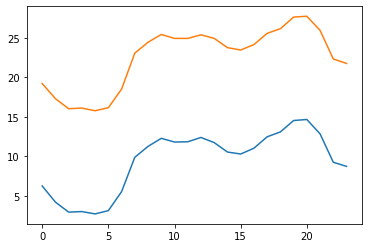

In [ ]:
#pattern
plt.plot(model_selected.trainable_weights[-3].numpy())

[<KerasTensor: shape=(None, 60, 100) dtype=float32 (created by layer 'raingauge_input')>,
 <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'DH_input')>,
 <KerasTensor: shape=(None, 60, 24) dtype=float32 (created by layer 'pattern_input')>]

In [ ]:
inp = model_selected.input[1]
outputs = [layer.output for layer in model_selected.layers]


In [ ]:
model_selected.layers[1]

In [ ]:
plt.plot(model_selected.trainable_weights[-3].numpy())

In [ ]:
log_results(linear_eval_dict, project, wandb.config)

ValueError: wandb.log must be passed a dictionary

## Sci-kit Learn - Logistic regression

# ROC curve for max threshold

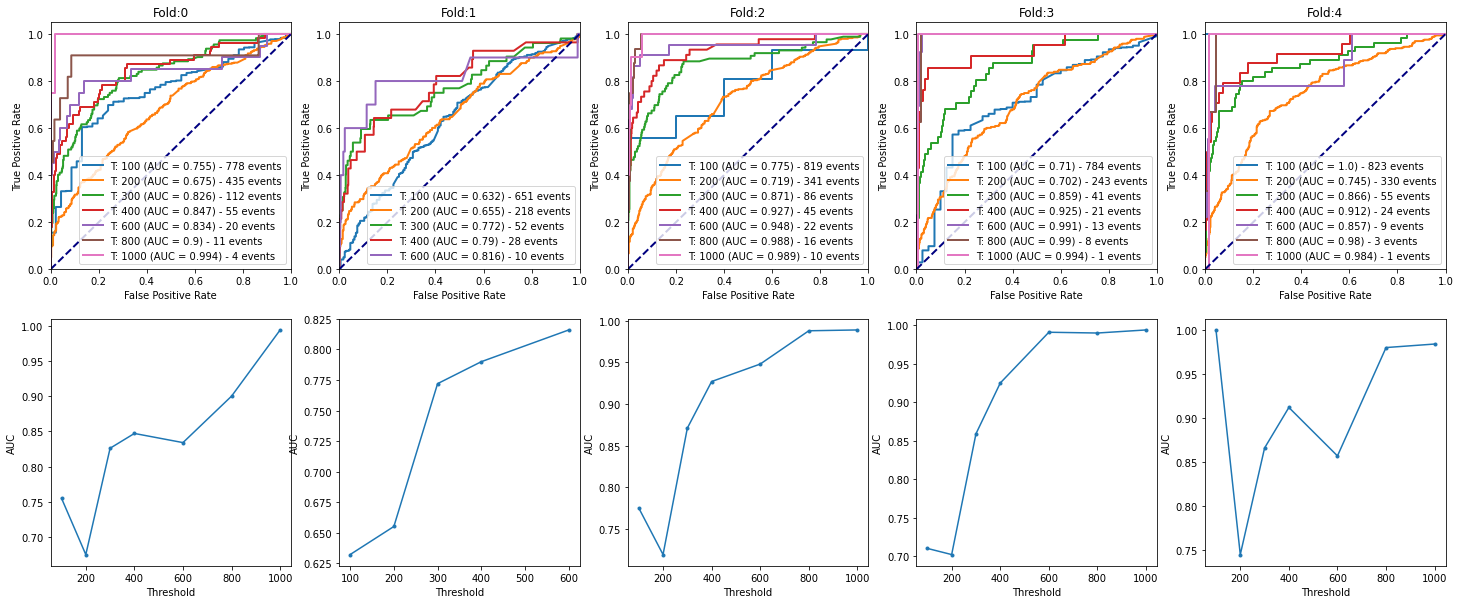

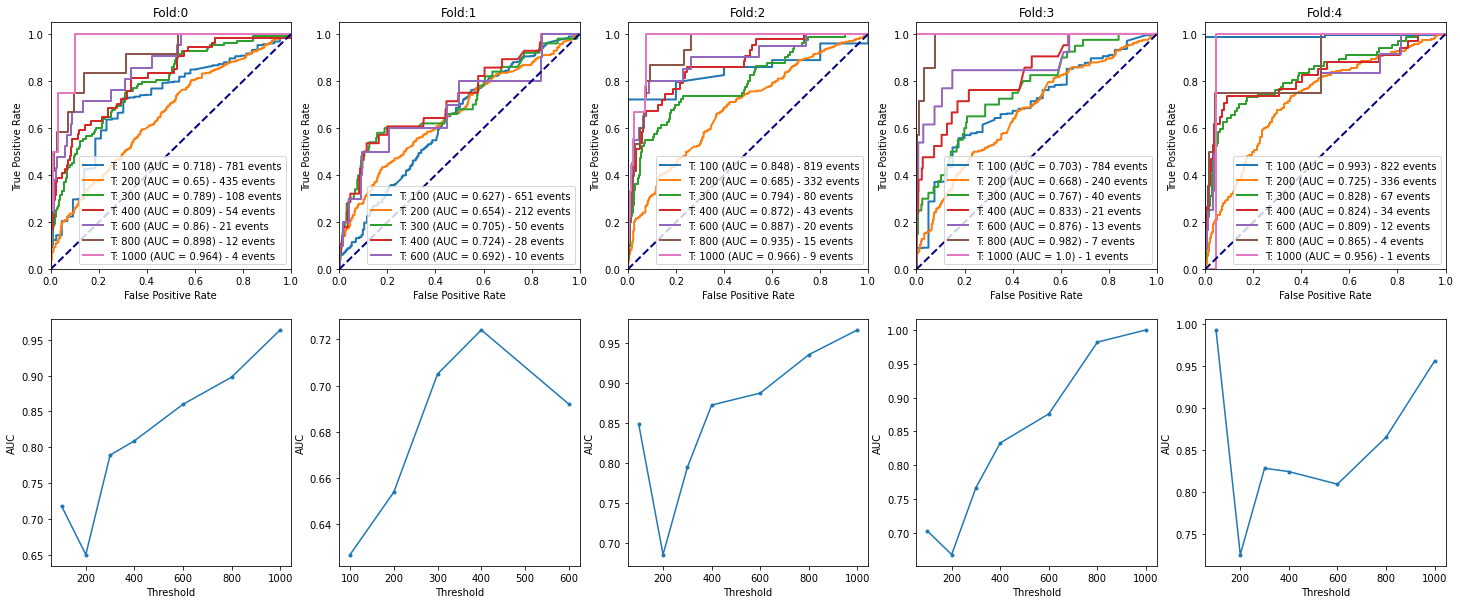

In [ ]:
from sklearn.metrics import roc_curve, auc


def ROC_from_IOP_per_fold(IOP, prediction_distance=24, sensor=0):
    f,axes = plt.subplots(2,5,figsize=(25, 10))
    
    for fold,(ax1,ax2) in zip(range(5),axes.T):
        y_preds = IOP[fold]['Y_val_pred'][:, prediction_distance, sensor, :]
        y_trues = IOP[fold]['Y_val'][:, prediction_distance, sensor, :]
        
        fpr, tpr, roc_auc = dict(), dict(), dict()
        used_thresholds = []
        for thresh in range(8):
            t_val = thresholds[sensor, thresh]

            y_trues_flat = y_trues[...,thresh].reshape(-1, 1)
            y_preds_flat = y_preds[...,thresh].reshape(-1, 1)
            
            n_false = sum(y_trues_flat == 0)[0]
            n_true = sum(y_trues_flat == 1)[0]
            if (n_true == 0) or (n_false == 0):
                continue
            used_thresholds.append(t_val)
            
            fpr[thresh], tpr[thresh], _ = roc_curve(y_trues_flat,y_preds_flat)
            roc_auc[thresh] = auc(fpr[thresh], tpr[thresh]).round(3)
            ax1.plot(fpr[thresh],    tpr[thresh],  lw=2,
                    label=\
                        f"T: {t_val} (AUC = {roc_auc[thresh]})" + 
                        f" - {(n_true)} events")
        
        ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title("Fold:" + str(fold))
        ax1.legend(loc="lower right")
        
        ax2.plot(used_thresholds, roc_auc.values(), marker = '.')
        ax2.set_xlabel('Threshold')
        ax2.set_ylabel('AUC')
    plt.show()
    
ROC_from_IOP_per_fold(con_class_simple_results['iop'],5)
ROC_from_IOP_per_fold(con_class_simple_results['iop'],-1)


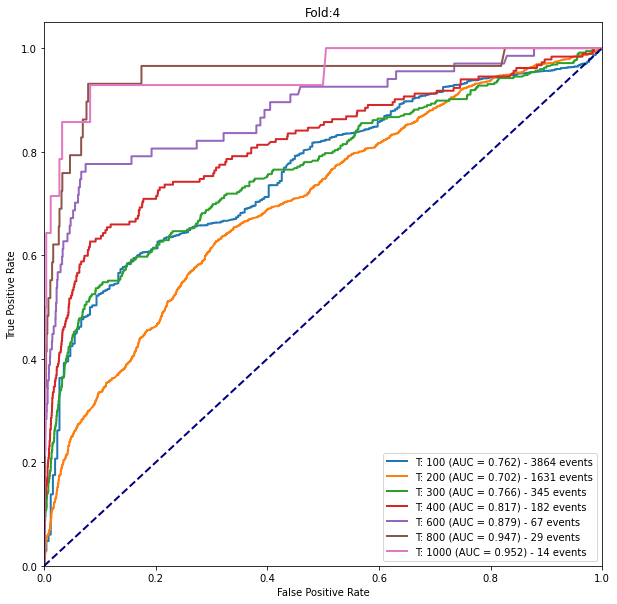

In [ ]:
from sklearn.metrics import roc_curve, auc


def ROC_from_IOP_over_all(IOP, prediction_distance=24, sensor=0):
    plt.figure(figsize=(10, 10))
    
    for thresh in range(8):
   
        y_preds = []
        y_trues = []
        
        fpr, tpr, roc_auc = dict(), dict(), dict()
        t_val = thresholds[sensor, thresh]
        
        for fold in range(5):
            y_pred = IOP[fold]['Y_val_pred'][:, prediction_distance, sensor, thresh]
            y_true = IOP[fold]['Y_val'][:, prediction_distance, sensor, thresh]
            y_preds.append(y_pred)
            y_trues.append(y_true)
            
        y_preds_flat = np.array(y_preds).reshape(-1, 1)
        y_trues_flat = np.array(y_trues).reshape(-1, 1)
        n_false = sum(y_trues_flat == 0)[0]
        n_true = sum(y_trues_flat == 1)[0]
        if (n_true == 0) or (n_false == 0):
            continue
        
        fpr[thresh], tpr[thresh], _ = roc_curve(y_trues_flat,y_preds_flat)
        
        roc_auc[thresh] = auc(fpr[thresh], tpr[thresh]).round(3)
        plt.plot(fpr[thresh],    tpr[thresh],  lw=2,
                label=\
                    f"T: {t_val} (AUC = {roc_auc[thresh]})" + 
                    f" - {(n_true)} events")
    
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Fold:" + str(fold))
    plt.legend(loc="lower right")
        
    
ROC_from_IOP_over_all(con_class_simple_results['iop'],48,0)
# ROC_from_IOP_over_all(con_class_simple_results['iop'],0,1)


In [ ]:
model_0 = con_class_simple_results['models'][0]


In [ ]:
len(model_0.layers)

8

In [ ]:
model_0.layers[-2].name

'add_1'

In [ ]:
model_0.layers

In [ ]:
model_regression = model_0.layers[-2]

TypeError: unsupported operand type(s) for +=: 'Sequential' and 'Sequential'

In [ ]:
model_0.get_output_at(8)

RuntimeError: The layer has never been called and thus has no defined output.

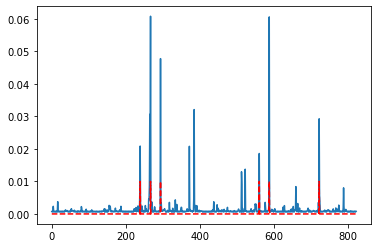

In [ ]:
plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][:,0,0,7])
plt.plot(con_class_simple_results['iop'][0]['Y_val'][:,0,0,7]*0.01,color='red',linestyle='--')

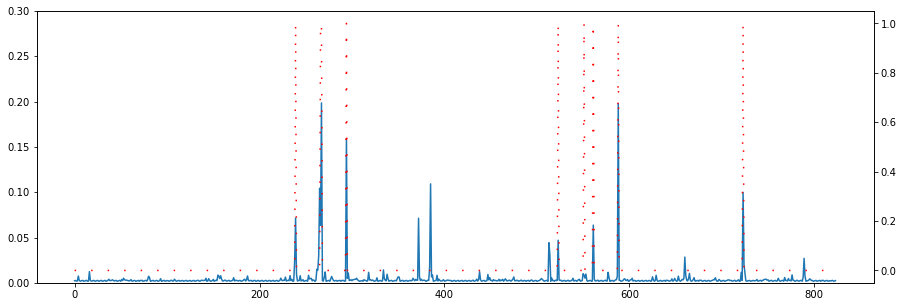

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(con_class_simple_results['iop'][0]['Y_val_pred'][:,0,0,6])
plt.ylim(0,0.3)
plt.twinx().plot(con_class_simple_results['iop'][0]['Y_val'][:,0,0,6],color='red',linestyle=(0,(1,10)))


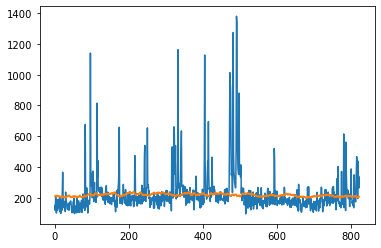

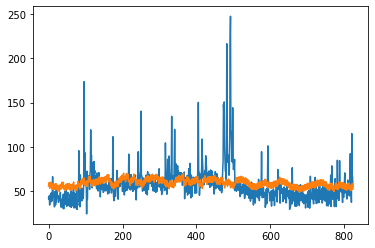

In [ ]:
plt.plot(con_simple_results['iop'][2]['Y_val'][:,0,0])
plt.plot(con_simple_results['iop'][2]['Y_val_pred'][:,0,0])
plt.show()

plt.plot(con_simple_results['iop'][2]['Y_val'][:,0,1])
plt.plot(con_simple_results['iop'][2]['Y_val_pred'][:,0,1])
plt.show()

# Create the model from scratch

In [ ]:
# # tf.random.set_seed(99)

# RR = Sequential([
#         Input(shape = (pred_dist, 100)),
#         Conv1D(filters=10,
#                kernel_size=1,
#                padding='causal',
#                activation='relu',
#                kernel_regularizer=tf.keras.regularizers.l2(
#             10)),
#         Conv1D(filters=2,
#                kernel_size=1,
#                padding='causal',
#                activation='linear')
#         # Dense(2,activation =  'linear'), 
#         ], 'rain_gauge')

In [ ]:
RR = Sequential([
        Input(shape = (pred_dist, 100)),
        Conv1D(filters=10,
               kernel_size=1,
               padding='causal',
               activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(
            10)),
        Dense(2,activation =  'linear'), ], 'rain_gauge')

In [ ]:

RR_input = Input(shape = (pred_dist, 100), name='rainfall_input')
DH_input = Input((pred_dist, 1,), name='DH_input')
DP_input = Input((pred_dist, 24,), name='pattern_input')

DH = construct_sequential(district_heating_layers,'District_heating')
PA = construct_sequential(pattern_layers,'Pattern')

# DH = District_heating()
# PA = Daily_pattern()

Rainfall_runoff_output = RR(RR_input)
District_heating_output = DH(DH_input)
Daily_pattern_output = PA(DP_input)


combined_output = tf.keras.layers.Add()([Rainfall_runoff_output,District_heating_output,Daily_pattern_output])


model = tf.keras.Model([RR_input,
                        DH_input,
                        DP_input],
                        combined_output)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=tf.losses.mean_squared_error)


In [ ]:
# model.predict([X1_tmp,X2_tmp,X3_tmp])

In [ ]:
X1_tmp = X1.reshape(-1, pred_dist, 100)
X2_tmp = X2.reshape(-1, pred_dist, 1)
X3_tmp = X3.reshape(-1, pred_dist, 24)

model.fit([X1_tmp,X2_tmp,X3_tmp],Y12, epochs = 10)

Epoch 1/10
155/155 [==============================] - 1s 3ms/step - loss: 4726.6357
Epoch 2/10
155/155 [==============================] - 1s 4ms/step - loss: 4694.2495
Epoch 3/10
155/155 [==============================] - 1s 4ms/step - loss: 4654.5195
Epoch 4/10
155/155 [==============================] - 1s 4ms/step - loss: 4648.6978
Epoch 5/10
155/155 [==============================] - 1s 4ms/step - loss: 4610.9424
Epoch 6/10
155/155 [==============================] - 1s 4ms/step - loss: 4580.5830
Epoch 7/10
155/155 [==============================] - 1s 4ms/step - loss: 4561.9263
Epoch 8/10
155/155 [==============================] - 1s 4ms/step - loss: 4580.5796
Epoch 9/10
155/155 [==============================] - 1s 4ms/step - loss: 4552.3857
Epoch 10/10
155/155 [==============================] - 1s 4ms/step - loss: 4561.9683


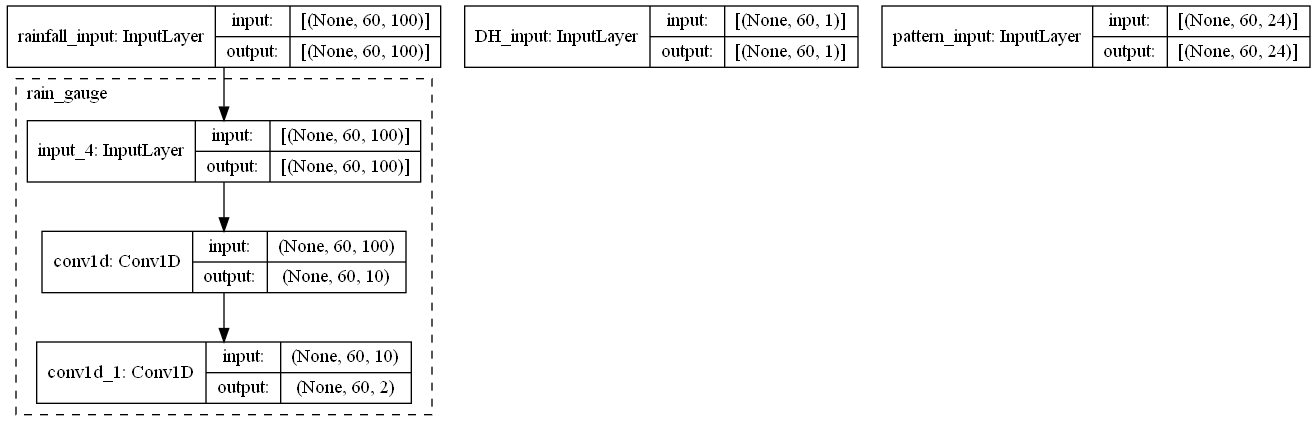

In [ ]:
tf.keras.utils.plot_model(model,
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)

In [ ]:
y_pred = model.predict([X1_tmp,X2_tmp,X3_tmp])

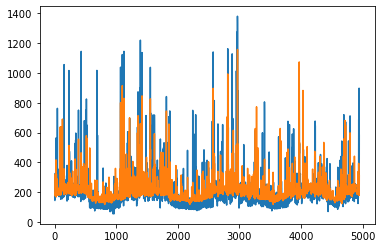

In [ ]:
plt.plot(Y12[:,0,0])
plt.plot(y_pred[:,0,0])


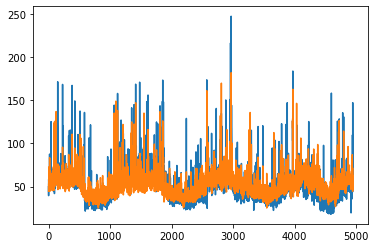

In [ ]:
plt.plot(Y12[:,0,1])
plt.plot(y_pred[:,0,1])

In [ ]:
# sigmoid output
classification_layer = Sequential([
    Input((pred_dist, 2)),
    Reshape((pred_dist, 2, 1)),
    Conv1D(8, 1, activation='sigmoid'),
    # Activation('sigmoid')
], 'classification_output')


In [ ]:

classification_layer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=tf.losses.binary_crossentropy)

In [ ]:

Y12_tmp_cls = np.zeros(Y12.shape + (8,))
for i, (t1, t2) in enumerate(thresholds.T):
    Y12_tmp_cls[:, :, 0, i] = (Y12[:, :, 0] > t1)*1
    Y12_tmp_cls[:, :, 1, i] = (Y12[:, :, 1] > t2)*1



In [ ]:
classification_layer.fit(y_pred,Y12_tmp_cls,epochs = 40)

Epoch 1/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1713
Epoch 2/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 3/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1725
Epoch 4/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1704
Epoch 5/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1708
Epoch 6/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 7/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1702
Epoch 8/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1720
Epoch 9/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1701
Epoch 10/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1709
Epoch 11/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1702
Epoch 12/40
155/155 [==============================] - 0s 2ms/step - loss: 0.1692
Epoch 13/40
155/155 [====

In [ ]:
y_pred_cls = classification_layer.predict(y_pred)

In [ ]:
def CLF_error(Y, Y_pred, thresh):
    Y_bool = Y == 1
    Y_pred_bool = Y_pred > thresh
    TP = np.sum(Y_bool & Y_pred_bool, axis=0)  # True True
    FP = np.sum(~Y_bool & Y_pred_bool, axis=0)  # False True
    TN = np.sum(~Y_bool & ~Y_pred_bool, axis=0)  # False False
    FN = np.sum(Y_bool & ~Y_pred_bool, axis=0)  # True False
    return TP, FP, TN, FN


fold = 4
y_trues_train = Y12_tmp_cls
y_preds_train = y_pred_cls

y_trues_val = Y12_tmp_cls
y_preds_val = y_pred_cls

thresh = 5
sensor = 0
prediction_distance = 60

y_true_train = y_trues_train[:,:prediction_distance, sensor, thresh].ravel()
y_pred_train = y_preds_train[:,:prediction_distance, sensor, thresh].ravel()

y_true_val = y_trues_val[:,:prediction_distance, sensor, thresh].ravel()
y_pred_val = y_preds_val[:,:prediction_distance, sensor, thresh].ravel()

performance_dict_val = {}
performance_dict_train = {}
performance_dict_val['CSI'] = []
performance_dict_train['CSI'] = []

performance_dict_val['precision'] = []
performance_dict_train['precision'] = []

performance_dict_val['recall'] = []
performance_dict_train['recall'] = []

performance_dict_val['false positive rate'] = []
performance_dict_train['false positive rate'] = []

performance_dict_val['true positive rate'] = []
performance_dict_train['true positive rate'] = []

performance_dict_val['f1'] = []
performance_dict_train['f1'] = []


prediction_thresholds = np.linspace(0,1,1000)
for pred_thresh in prediction_thresholds:
    TP, FP, TN, FN = CLF_error(y_true_val, y_pred_val, pred_thresh)
    performance_dict_val['CSI'].append(TP/(TP + FP + FN))
    performance_dict_val['precision'].append(TP/(TP+FP))
    performance_dict_val['recall'].append(TP/(TP+FN))
    performance_dict_val['false positive rate'].append(FP/(FP+TN))
    performance_dict_val['true positive rate'].append(TP/(TP+FN))
    performance_dict_val['f1'].append(TP/(TP + 1/2*(FP+FN)))
    
    TP, FP, TN, FN = CLF_error(y_true_train, y_pred_train, pred_thresh)
    performance_dict_train['CSI'].append(TP/(TP + FP + FN))
    performance_dict_train['precision'].append(TP/(TP+FP))
    performance_dict_train['recall'].append(TP/(TP+FN))
    performance_dict_train['false positive rate'].append(FP/(FP+TN))
    performance_dict_train['true positive rate'].append(TP/(TP+FN))
    performance_dict_train['f1'].append(TP/(TP + 1/2*(FP+FN)))
    
    

C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_40168/3848898744.py:53: RuntimeWarning: invalid value encountered in long_scalars
  performance_dict_val['precision'].append(TP/(TP+FP))
C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_40168/3848898744.py:61: RuntimeWarning: invalid value encountered in long_scalars
  performance_dict_train['precision'].append(TP/(TP+FP))


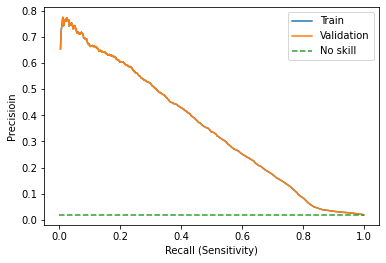

In [ ]:
plt.plot(performance_dict_train['recall'],performance_dict_train['precision'])
plt.plot(performance_dict_val['recall'],performance_dict_val['precision'])

no_skill = len(y_true_val[y_true_val==1]) / len(y_true_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precisioin')
plt.legend(['Train','Validation','No skill'])
plt.show()

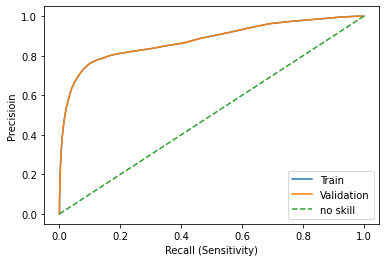

In [ ]:
plt.plot(performance_dict_train['false positive rate'],performance_dict_train['true positive rate'])
plt.plot(performance_dict_val['false positive rate'],performance_dict_val['true positive rate'])
plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precisioin')
plt.legend(['Train','Validation','no skill'])

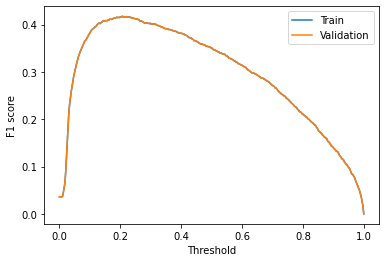

In [ ]:
plt.plot(prediction_thresholds,performance_dict_train['f1'])
plt.plot(prediction_thresholds,performance_dict_val['f1'])
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.legend(['Train','Validation','no skill'])

In [22]:
for a in [0,10]:
    for d in ['NWP','radar','gauge']:
        for i in ['r','rt','rth']:
            for w in ['same','shi_mirror']:
                string = f'python train_and_test_linear.py -a {a} -d {d} -i {i} -w {w}'
                if d == 'NWP':
                    for o in [3]:
                        print(string + f' -o {o}')
                print(string)

python train_and_test_linear.py -a 0 -d NWP -i r -w same -o 3
python train_and_test_linear.py -a 0 -d NWP -i r -w same
python train_and_test_linear.py -a 0 -d NWP -i r -w shi_mirror -o 3
python train_and_test_linear.py -a 0 -d NWP -i r -w shi_mirror
python train_and_test_linear.py -a 0 -d NWP -i rt -w same -o 3
python train_and_test_linear.py -a 0 -d NWP -i rt -w same
python train_and_test_linear.py -a 0 -d NWP -i rt -w shi_mirror -o 3
python train_and_test_linear.py -a 0 -d NWP -i rt -w shi_mirror
python train_and_test_linear.py -a 0 -d NWP -i rth -w same -o 3
python train_and_test_linear.py -a 0 -d NWP -i rth -w same
python train_and_test_linear.py -a 0 -d NWP -i rth -w shi_mirror -o 3
python train_and_test_linear.py -a 0 -d NWP -i rth -w shi_mirror
python train_and_test_linear.py -a 0 -d radar -i r -w same
python train_and_test_linear.py -a 0 -d radar -i r -w shi_mirror
python train_and_test_linear.py -a 0 -d radar -i rt -w same
python train_and_test_linear.py -a 0 -d radar -i rt -w

In [1]:
for w in ['same','shi_mirror']:
    for i in ['r','rt','rth']:
        for u in [1,3]:
            for o in [1,3]:
                for d in ['NWP','radar','gauge']:
                    string = f'python train_and_test_recurrent.py -u {u} -d {d} -i {i} -w {w} -o {o}'
                    print(string)
                    

python train_and_test_recurrent.py -u 1 -d NWP -i r -w same -o 1
python train_and_test_recurrent.py -u 1 -d radar -i r -w same -o 1
python train_and_test_recurrent.py -u 1 -d gauge -i r -w same -o 1
python train_and_test_recurrent.py -u 1 -d NWP -i r -w same -o 3
python train_and_test_recurrent.py -u 1 -d radar -i r -w same -o 3
python train_and_test_recurrent.py -u 1 -d gauge -i r -w same -o 3
python train_and_test_recurrent.py -u 3 -d NWP -i r -w same -o 1
python train_and_test_recurrent.py -u 3 -d radar -i r -w same -o 1
python train_and_test_recurrent.py -u 3 -d gauge -i r -w same -o 1
python train_and_test_recurrent.py -u 3 -d NWP -i r -w same -o 3
python train_and_test_recurrent.py -u 3 -d radar -i r -w same -o 3
python train_and_test_recurrent.py -u 3 -d gauge -i r -w same -o 3
python train_and_test_recurrent.py -u 1 -d NWP -i rt -w same -o 1
python train_and_test_recurrent.py -u 1 -d radar -i rt -w same -o 1
python train_and_test_recurrent.py -u 1 -d gauge -i rt -w same -o 1
py

In [7]:
for w in ['same','shi_mirror']:
    for f in [1,3]:
        for a in [1,3]:
            for o in [1,3]:
                for d in ['NWP','radar','gauge']:
                    string = f'python train_and_test_conceptual.py -f {f} -a {a} -d {d} -w {w} -o {o} -t True'
                    print(string)
                    

python train_and_test_conceptual.py -f 1 -a 1 -d NWP -w same -o 1 -t True
python train_and_test_conceptual.py -f 1 -a 1 -d radar -w same -o 1 -t True
python train_and_test_conceptual.py -f 1 -a 1 -d gauge -w same -o 1 -t True
python train_and_test_conceptual.py -f 1 -a 1 -d NWP -w same -o 3 -t True
python train_and_test_conceptual.py -f 1 -a 1 -d radar -w same -o 3 -t True
python train_and_test_conceptual.py -f 1 -a 1 -d gauge -w same -o 3 -t True
python train_and_test_conceptual.py -f 1 -a 3 -d NWP -w same -o 1 -t True
python train_and_test_conceptual.py -f 1 -a 3 -d radar -w same -o 1 -t True
python train_and_test_conceptual.py -f 1 -a 3 -d gauge -w same -o 1 -t True
python train_and_test_conceptual.py -f 1 -a 3 -d NWP -w same -o 3 -t True
python train_and_test_conceptual.py -f 1 -a 3 -d radar -w same -o 3 -t True
python train_and_test_conceptual.py -f 1 -a 3 -d gauge -w same -o 3 -t True
python train_and_test_conceptual.py -f 3 -a 1 -d NWP -w same -o 1 -t True
python train_and_test_

In [3]:
for w in ['same','shi_mirror']:
    for f in [1,3]:
        for a in [1,3]:
            for o in [1,3]:
                for d in ['NWP','radar','gauge']:
                    string = f'python train_and_test_conceptual_recurrent.py -f {f} -a {a} -d {d} -w {w} -o {o} -t True'
                    print(string)
                    

python train_and_test_conceptual_recurrent.py -f 1 -a 1 -d NWP -w same -o 1 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 1 -d radar -w same -o 1 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 1 -d gauge -w same -o 1 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 1 -d NWP -w same -o 3 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 1 -d radar -w same -o 3 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 1 -d gauge -w same -o 3 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 3 -d NWP -w same -o 1 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 3 -d radar -w same -o 1 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 3 -d gauge -w same -o 1 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 3 -d NWP -w same -o 3 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 3 -d radar -w same -o 3 -t True
python train_and_test_conceptual_recurrent.py -f 1 -a 3 -d gau

In [5]:
a = {'a':1,'b':2,'c':3}
{key:value for key,value in a.items() if value<3}

{'a': 1, 'b': 2}

In [1]:
from train_and_test_conceptual import train_model

In [2]:
fake_args = ["--filters", '1',
                "-d", "radar",
                "-w", "same",
                "-o", "1",
                "-t","True"
                ]
train_model(fake_args)

In [1]:
from train_and_test_linear import train_model as train_linear

In [2]:
fake_args = ["-a", '0',
                "-d", "gauge",
                "-w", "same",
                "-o", "1",
                '-i','rth',
                ]
train_linear(fake_args)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sverrirhd (use `wandb login --relogin` to force relogin)
C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.73201e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


total_mean_absolute_error,▁
total_mean_squared_error,▁
total_weighted_mean_absolute_error,▁
total_weighted_mean_squared_error,▁
total_mean_absolute_error,30.10036
total_mean_squared_error,3355.33571
total_weighted_mean_absolute_error,30.10036
total_weighted_mean_squared_error,3355.33571


In [7]:
import os
os.path.dirname(os.path.realpath(__file__) )

NameError: name '__file__' is not defined